In [2]:
import os
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import warnings
import os
import random
import glob
import nibabel as nib
import numpy as np
from scipy.ndimage import rotate
import csv
import SimpleITK as sitk
#from lungtumormask import mask as tumormask
#from lungmask import mask as lungmask_fun
#from skimage.measure import label, regionprops,shannon_entropy
#from skimage.morphology import dilation,ball,erosion,remove_small_objects

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChannel,
    EnsureChannelFirst,
    ResizeWithPadOrCropd,
    MapTransform,
    MaskIntensityd,
    ScaleIntensityd,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    ResizeWithPadOrCrop,
    LoadImaged,
    Orientationd,
    ThresholdIntensity,
    KeepLargestConnectedComponent,
    RandCropByPosNegLabeld,
    SaveImaged,
    CenterSpatialCropd,
    SpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    AsDiscrete,
    SpatialCrop,
    SpatialPadd,
    EnsureTyped,
    EnsureType,
    DivisiblePadd,
    ToTensord,
    Transpose,
    ScaleIntensity,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch,pad_list_data_collate

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

if True:
    get_ipython().run_line_magic('matplotlib', 'inline')
    print('plot in line')

device: cuda
plot in line


In [4]:
# class to transpose lung mask
class Create_sequences(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        print(f"keys to transpose: {self.keys}")

    def __call__(self, dictionary):
        dictionary = dict(dictionary)
        for key in self.keys:
            data = dictionary[key]
            if key == 'lung':
                data = np.transpose(data, (0, 2, 3, 1))
                data = rotate(data, 270, axes=(1, 2), reshape=False)
                data = np.flip(data, 1)
                data[data == 2] = int(1)
                data[data != 1] = int(0)
            dictionary[key] = data

        return dictionary


In [27]:

# root_path = '/data/p308104/Nifti_Imgs_V0/' #UMCG data on peregrine
#root_path = '/data/p308104/MultipleBP/'
#root_path = '/home/umcg/OneDrive/MultipleBreathingP/'
root_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti/'
#root_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti_AllBP_V2/'

figures_path = '/home/umcg/Desktop/AutomaticITV_code/figures_folder_i/'
figures_folder_i = figures_path+'figures_SwinDyn_V11_ITV'

average_folder_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti_Averages_CT/'
gtv_folder_path = '/home/umcg/Desktop/AutomaticITV_code/SABR1322_Nifti_GTVlabels/'

In [28]:
def LookSortFiles(root_path, all_patientdir):
    CTALL_fpaths =[]
    lungALL_fpaths =[]
    itv_fpaths = []
    gtv_fpaths = []  
    gtvNo_fpaths = []
    gtvYes_fpaths = [] 
    predicted_fpaths_yes = []
    predicted_fpaths_no = []
    average_path = []
    for patient_path in all_patientdir:
        average_miss = 0
        for root, dirs, files in os.walk(average_folder_path + patient_path, topdown=False):
            for f in files:
                if 'ave' in f.lower():
                    average_miss+=1
                    average_path.append(os.path.join(average_folder_path, patient_path, f))
    for patient_path in all_patientdir:
        gtv_miss = 0
        for root, dirs, files in os.walk(gtv_folder_path + patient_path, topdown=False):
            for f in files:
                if 'gtv' in f.lower():
                    gtv_miss+=1
                    gtv_fpaths.append(os.path.join(gtv_folder_path, patient_path, f))
    
    for patient_path in all_patientdir:
        ct_miss = 0
        gtvNo_miss =0
        gtvYes_miss = 0
        itv_miss = 0
        lung_miss = 0
        predicted_miss_yes = 0
        predicted_miss_no =0
        print(patient_path)
        for root, dirs, files in os.walk(root_path + patient_path, topdown=False):
            for f in files:
                if "predicteditv_allbp_yes" in f.lower():
                    predicted_fpaths_yes.append(os.path.join(root_path, patient_path, f))
                    predicted_miss_yes+=1
                if "predicteditv_allbp_no" in f.lower():
                    predicted_fpaths_no.append(os.path.join(root_path, patient_path, f))
                    predicted_miss_no+=1
                if "gtv" in f.lower() and "5bp" in f.lower() and "yes" in f.lower():
                    gtvYes_fpaths.append(os.path.join(root_path, patient_path, f))
                    gtvYes_miss +=1
                if "gtv" in f.lower() and "5bp" in f.lower() and "no" in f.lower():
                    gtvNo_fpaths.append(os.path.join(root_path, patient_path, f))
                    gtvNo_miss +=1
                if "pproved" in f.lower():
                    itv_fpaths.append(os.path.join(root_path, patient_path, f))
                    itv_miss +=1
                if "50%" in f.lower() and not("ave" in f.lower()):
                    if "ct" in f.lower():                            
                        CTALL_fpaths.append(os.path.join(root_path, patient_path, f))
                        ct_miss +=1
                    if "lung" in f.lower():
                        lungALL_fpaths.append(os.path.join(root_path, patient_path, f))
                        lung_miss +=1

    print('ct: ',ct_miss,"gtv",gtv_miss,"Lungs: ",lung_miss, "ITVLabel: ",itv_miss,"pITV yes",predicted_miss_yes,"pITV no",predicted_miss_no,"Ave",average_miss,"GTV yes",gtvYes_miss,"GTV No",gtvNo_miss)
    if gtv_miss ==0 and average_miss!=0:
        print("No GTV, will show ITV twice instead")
        return average_path, itv_fpaths,itv_fpaths, lungALL_fpaths, predicted_fpaths_yes,predicted_fpaths_no,gtvYes_fpaths,gtvNo_fpaths
    elif gtv_miss !=0 and average_miss!=0:
        return average_path, itv_fpaths,gtv_fpaths, lungALL_fpaths, predicted_fpaths_yes,predicted_fpaths_no,gtvYes_fpaths,gtvNo_fpaths
    elif gtv_miss !=0 and average_miss==0:
        print("No Average, will show 50% instead")
        return CTALL_fpaths, itv_fpaths,gtv_fpaths, lungALL_fpaths, predicted_fpaths_yes,predicted_fpaths_no,gtvYes_fpaths,gtvNo_fpaths
    elif gtv_miss ==0 and average_miss==0:
        print("No GTV, will show ITV twice instead")
        print("No Average, will show 50% instead")
        return CTALL_fpaths, itv_fpaths,itv_fpaths, lungALL_fpaths, predicted_fpaths_yes,predicted_fpaths_no,gtvYes_fpaths,gtvNo_fpaths
    
#return CTALL_fpaths, itv_fpaths,gtv_fpaths, lungALL_fpaths, predicted_fpaths_yes,predicted_fpaths_no,average_path

In [30]:
def LookSortFiles_GTV_Eval(root_path, all_patientdir):
    CTALL_fpaths =[]
    lungALL_fpaths =[]
    gtv_fpaths = []  
    gtv_miss = 0
    ct_miss =0
    lung_miss=0
    for patient_path in all_patientdir:
        for root, dirs, files in os.walk(average_folder_path + patient_path, topdown=False):
            for f in files:
                if '_gtv' in f.lower():
                    gtv_miss+=1
                    gtv_fpaths.append(os.path.join(average_folder_path, patient_path, f))
                if '_ct' in f.lower():
                    ct_miss+=1
                    CTALL_fpaths.append(os.path.join(average_folder_path, patient_path, f))
                if 'lung' in f.lower():
                    lung_miss += 1
                    lungALL_fpaths.append(os.path.join(average_folder_path, patient_path, f))
    return CTALL_fpaths, lungALL_fpaths,gtv_fpaths

In [31]:
# HU are -1000 air , 0 water , usually normal tissue are around 0, top values should be around 100, bones are around 1000
minmin_CT = -1024
maxmax_CT = 200 
#Create Compose functions for preprocessing of train and validation
image_keys = ["image","lung","ITV","pITV_yes","pITV_no","GTV_yes","GTV_no","GTV_label"]
size = 96
image_size = (size,size,size)
multiplier = 2
val_transforms = Compose(
    [
        LoadImaged(keys=["image","lung","ITV","pITV_yes","pITV_no","GTV_yes","GTV_no","GTV_label"]),
        EnsureChannelFirstd(keys=["image","lung","ITV","GTV_label"]),
        Orientationd(keys=["image","ITV","pITV_yes","pITV_no","GTV_yes","GTV_no","GTV_label"], axcodes="RAS"),
        #Spacingd(keys=["image","label"], pixdim=(1,1,1),mode=("bilinear","nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=minmin_CT, a_max=maxmax_CT,b_min=0.0, b_max=1.0, clip=True,),
        Create_sequences(keys=["image","ITV","lung","GTV_label"]),
        CropForegroundd(keys=["image","ITV","lung","GTV_label"], source_key="lung",k_divisible = size),
        ResizeWithPadOrCropd(keys=["image","ITV","lung","GTV_yes","GTV_no","GTV_label"],spatial_size=(384, 384, 192), method="symmetric"),
        #MaskIntensityd(keys=["image"], mask_key="lung"),
        CropForegroundd(keys=image_keys, source_key="GTV_no",k_divisible = size*multiplier),
        AsDiscreted(keys=["pITV_yes","pITV_no",],to_onehot=None,threshold=.01),
        ToTensord(keys=["image","ITV","lung","pITV_yes","pITV_no","GTV_yes","GTV_no","GTV_label"]),
    ]
)


keys to transpose: ('image', 'ITV', 'lung', 'GTV_label')


In [26]:
##MAIN
px_ = '483596/'
all_patientdir = []
all_patientdir.append(px_)
#all_patientdir = os.listdir(root_path)
all_patientdir.sort()
CTALL_fpaths, itv_fpaths,gtv_fpaths, lungALL_fpaths,predicted_fpaths_yes,predicted_fpaths_no,gtvYes_fpaths,gtvNofpaths = LookSortFiles(root_path, all_patientdir)
    
#Create data dictionat
data_dicts = [
    {"image": image_name,"lung":lung_name,"ITV":itv_name,"pITV_yes":predicted_name_yes,"pITV_no":predicted_name_no,"GTV_yes":gtvYes_name,"GTV_no":gtvNo_name,"GTV_label":gtv_name}
    for image_name,lung_name,itv_name,predicted_name_yes,predicted_name_no,gtvYes_name,gtvNo_name,gtv_name in zip(CTALL_fpaths,lungALL_fpaths,itv_fpaths,predicted_fpaths_yes,predicted_fpaths_no,gtvYes_fpaths,gtvNofpaths,gtv_fpaths)
]
val_files =data_dicts[:]
print('CT val len:',len(val_files))


483596/
ct:  0 gtv 0 Lungs:  0 ITVLabel:  0 pITV yes 0 pITV no 0 Ave 0 GTV yes 0 GTV No 0
No GTV, will show ITV twice instead
No Average, will show 50% instead
CT val len: 0


In [22]:
#Check the images after the preprocessing
figsize = (18, 9)
check_ds =Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1,num_workers=0)    
batch_data = first(check_loader)
px = batch_data["image"].to('cpu').meta["filename_or_obj"][0].split('/')[-2]
image,lung, label_ITV,pITV_yes,pITV_no,gtv_yes,gtv_no,gtv_label = (batch_data["image"][0][0],batch_data["lung"][0][0],batch_data["ITV"][0][0],batch_data["pITV_yes"][0][0],batch_data["pITV_no"][0][0],batch_data["GTV_yes"][0][0],batch_data["GTV_no"][0][0],batch_data["GTV_label"][0][0])

Px: 0070683


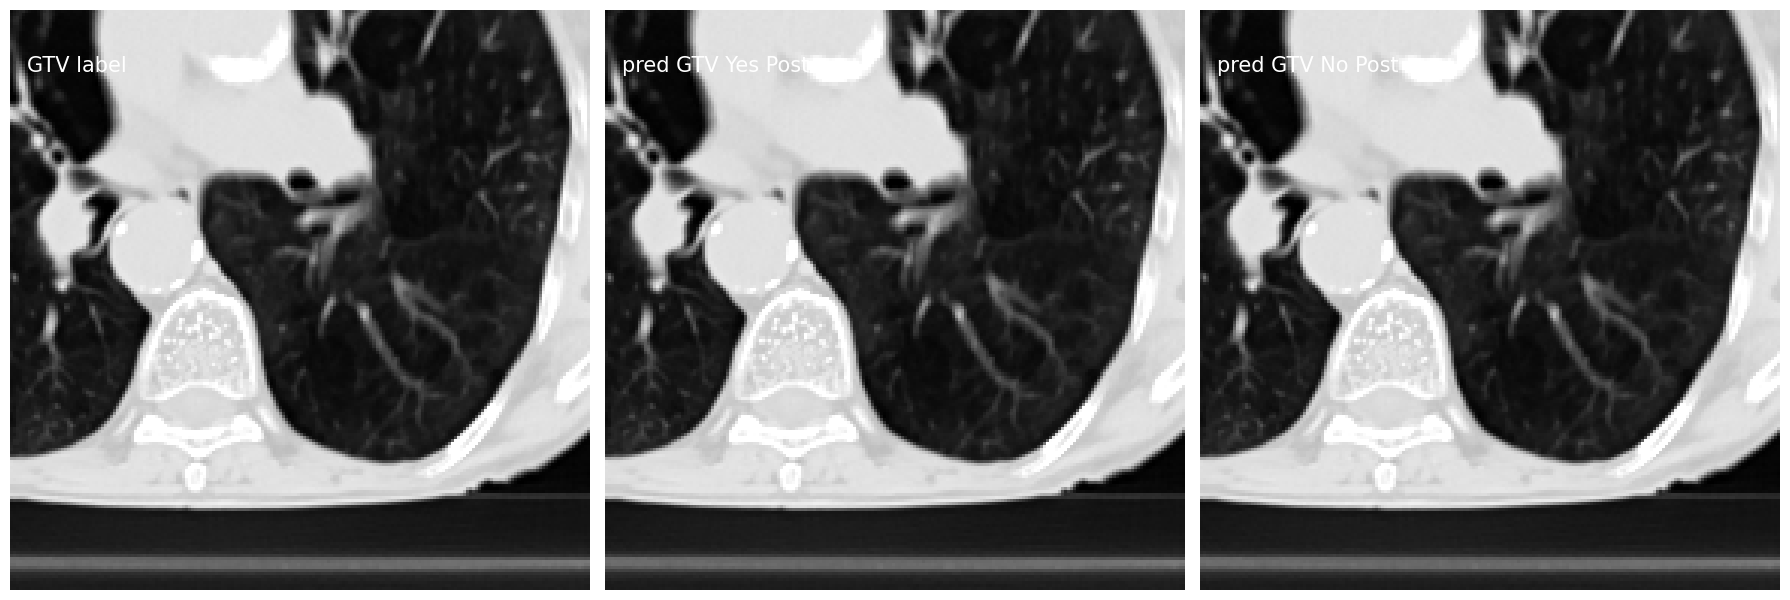

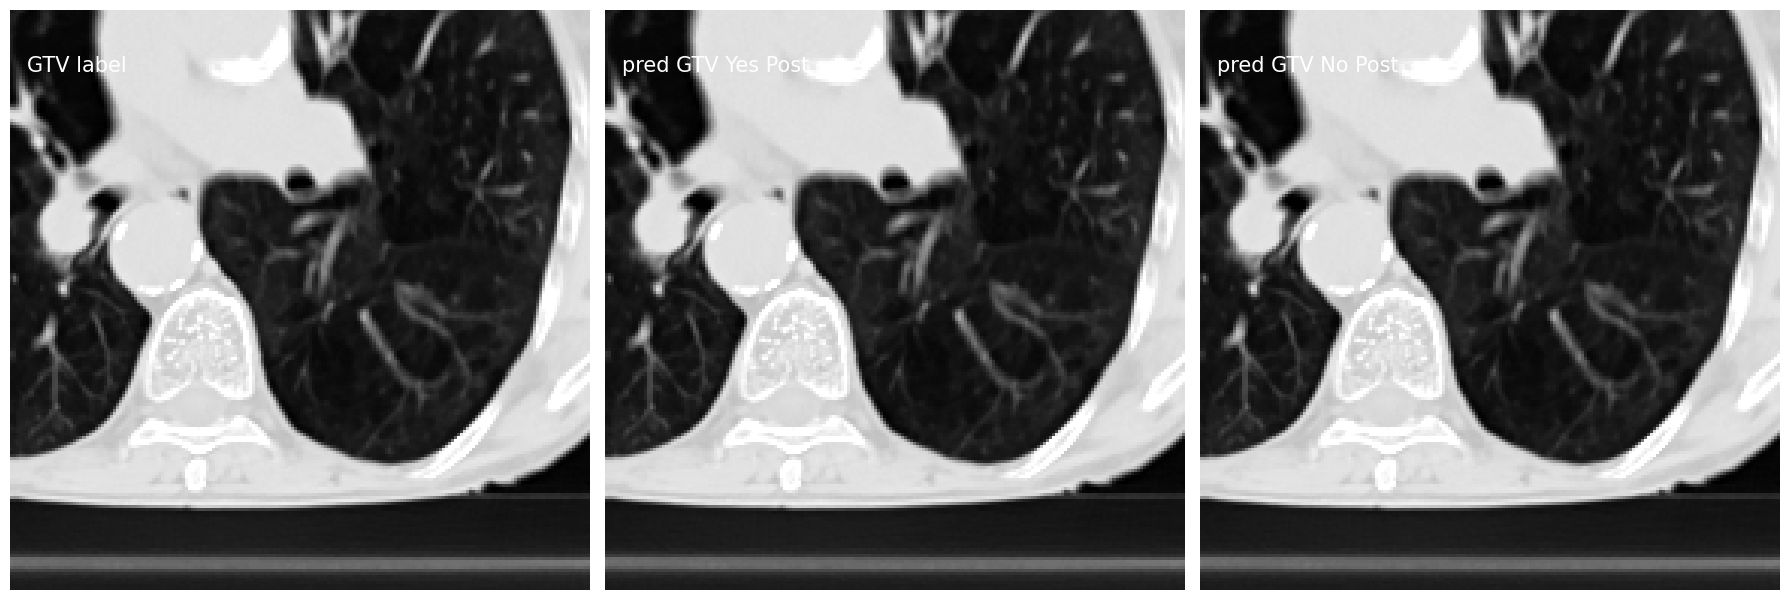

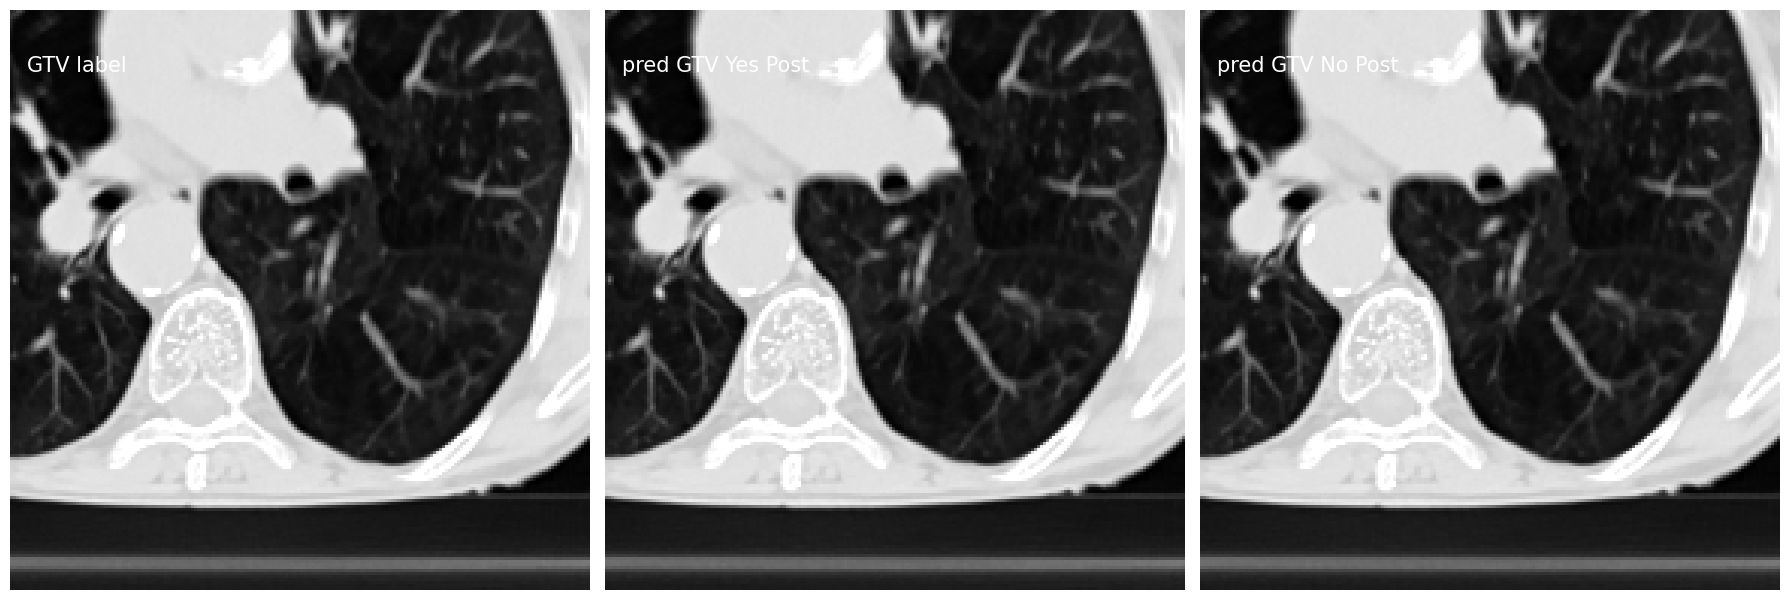

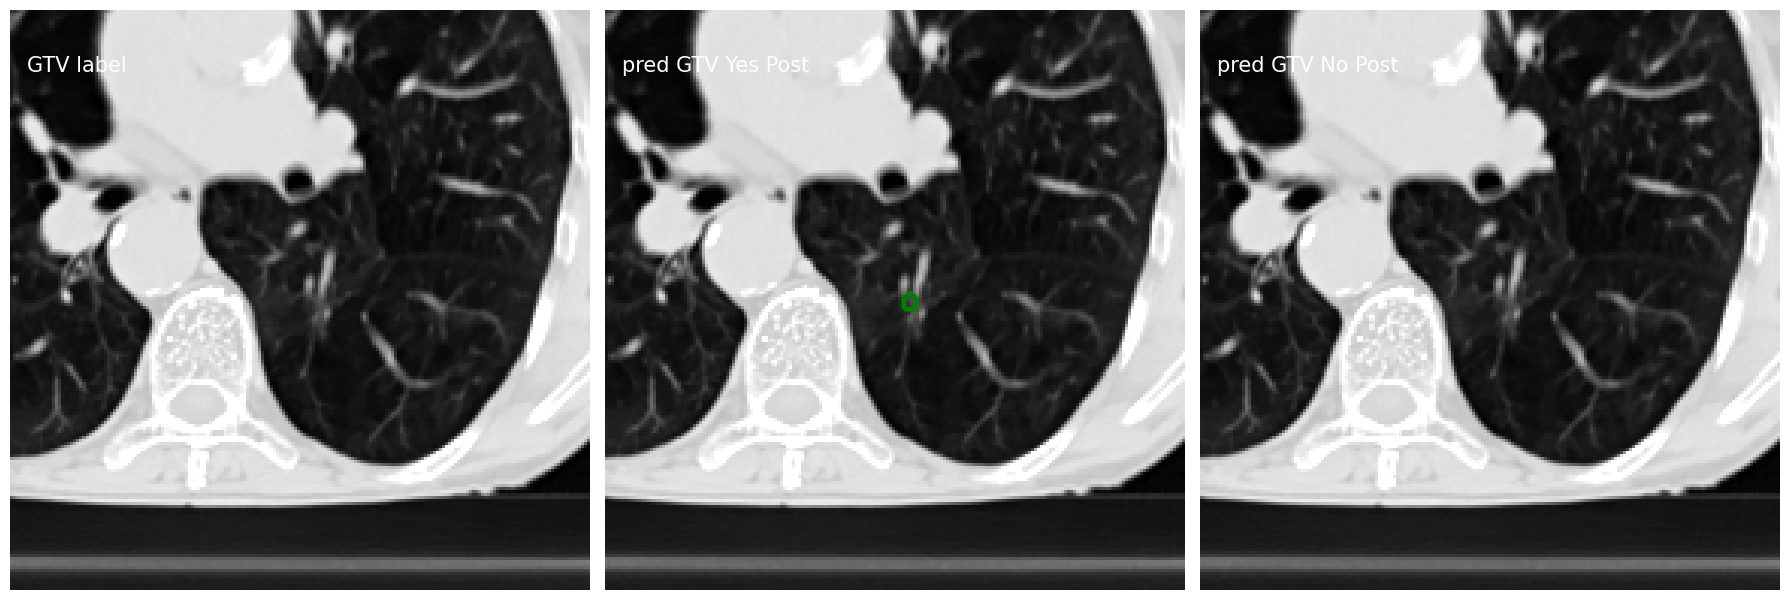

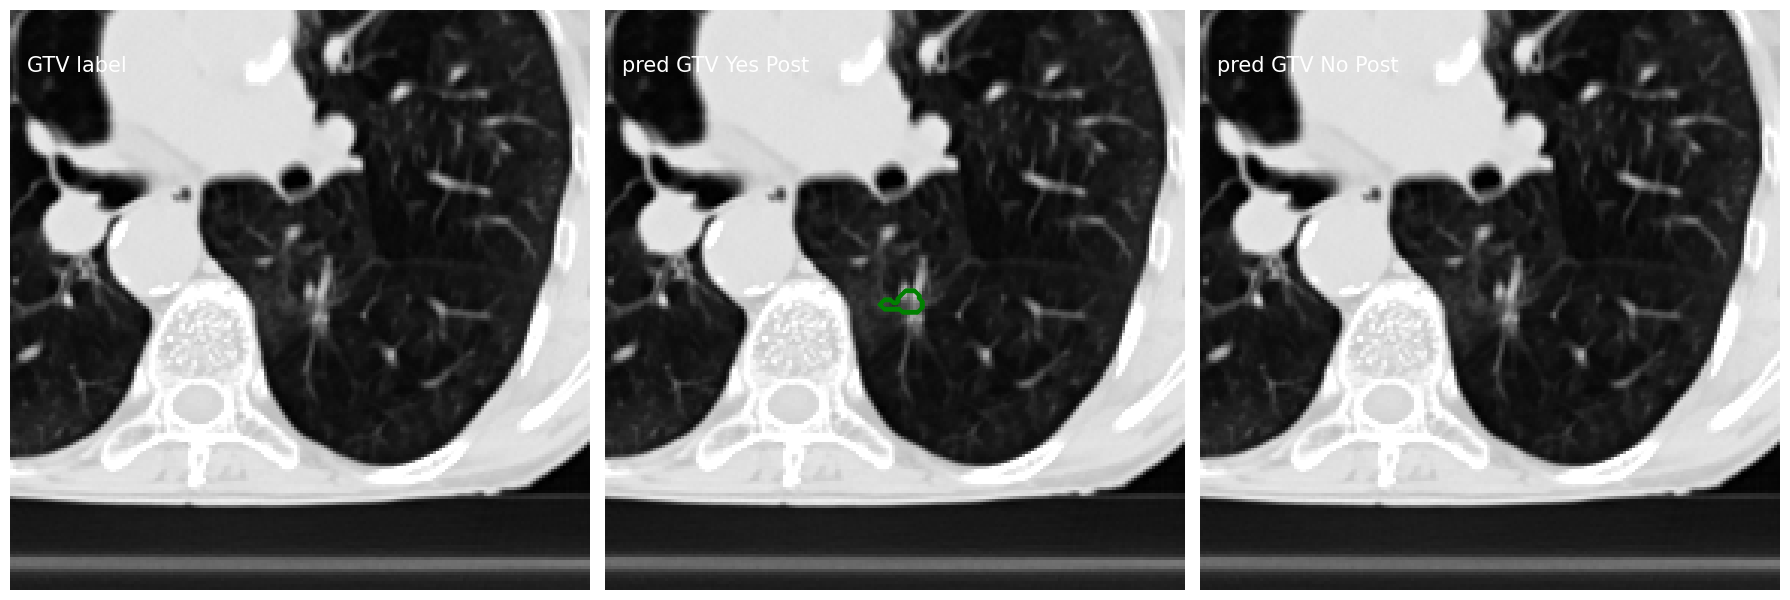

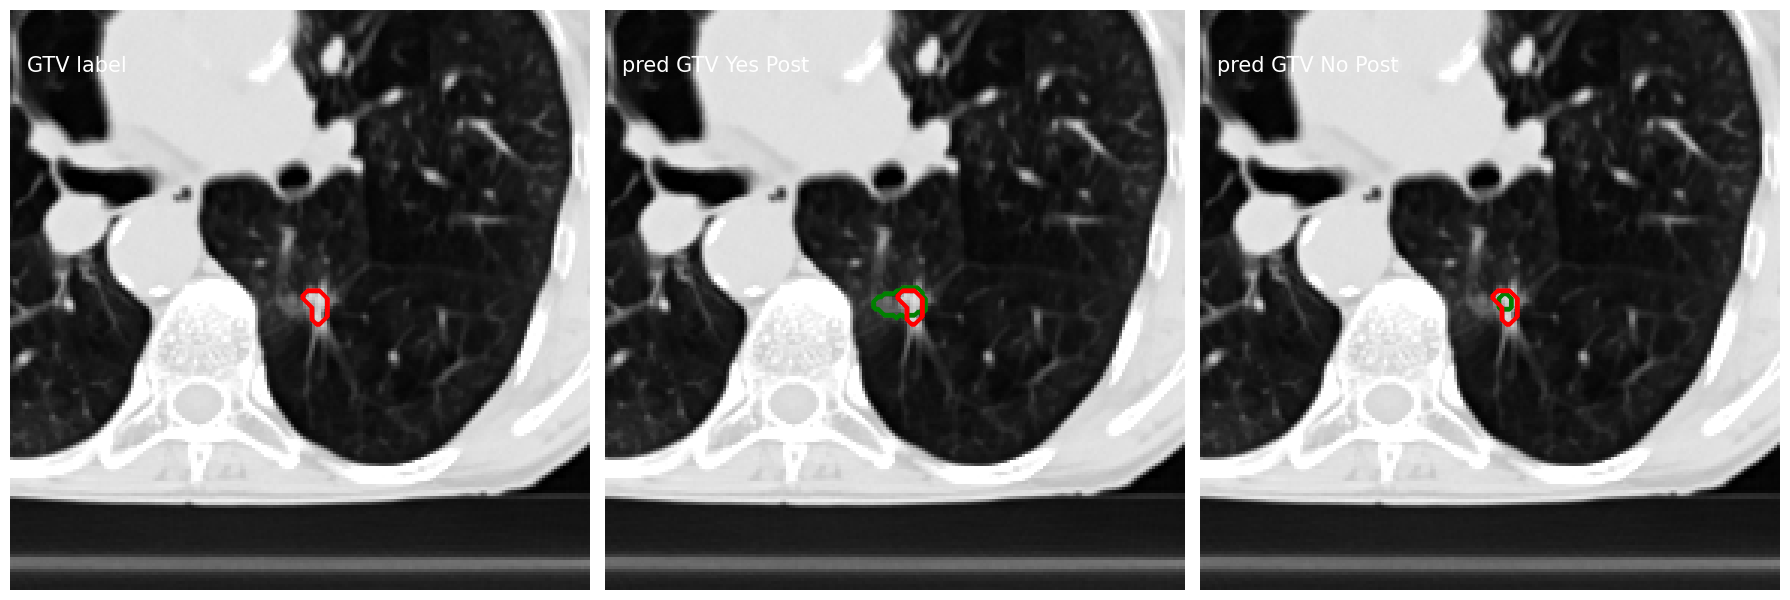

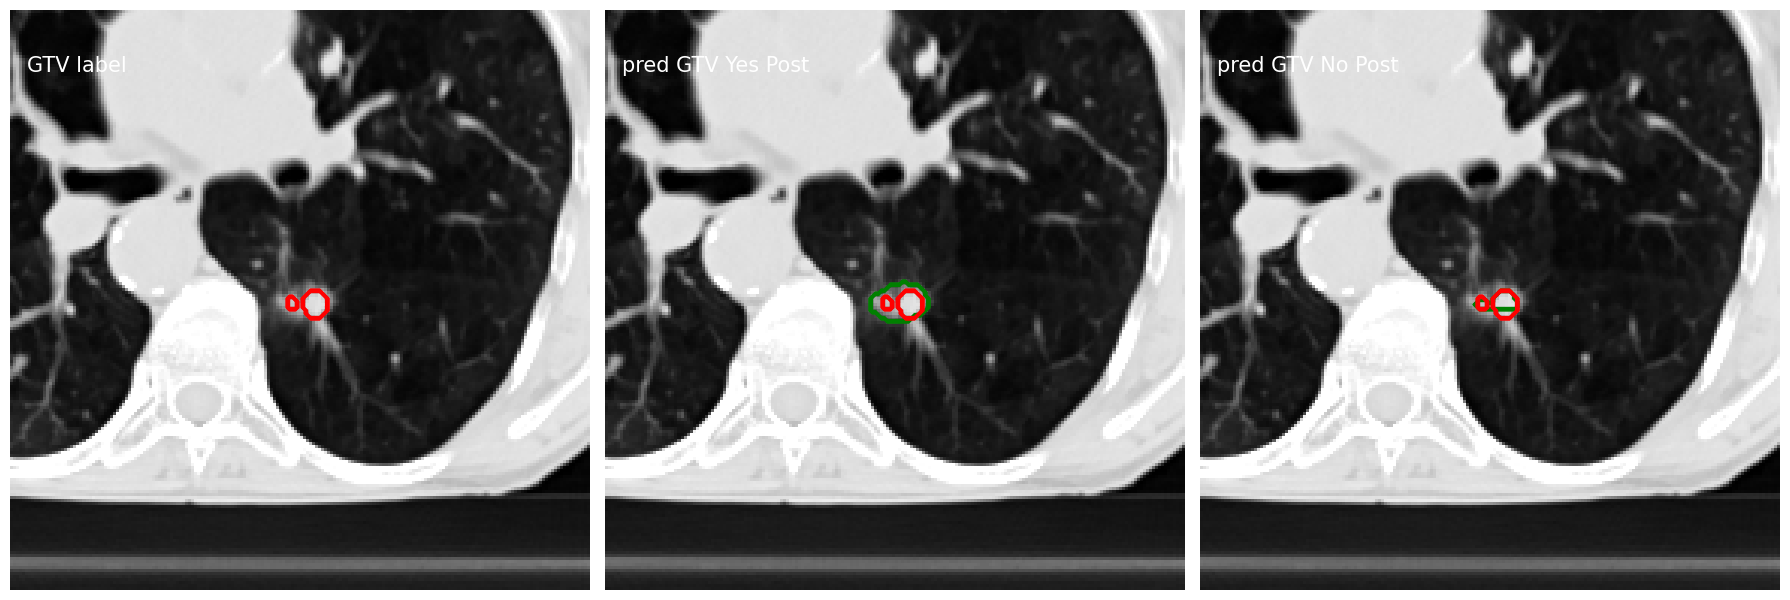

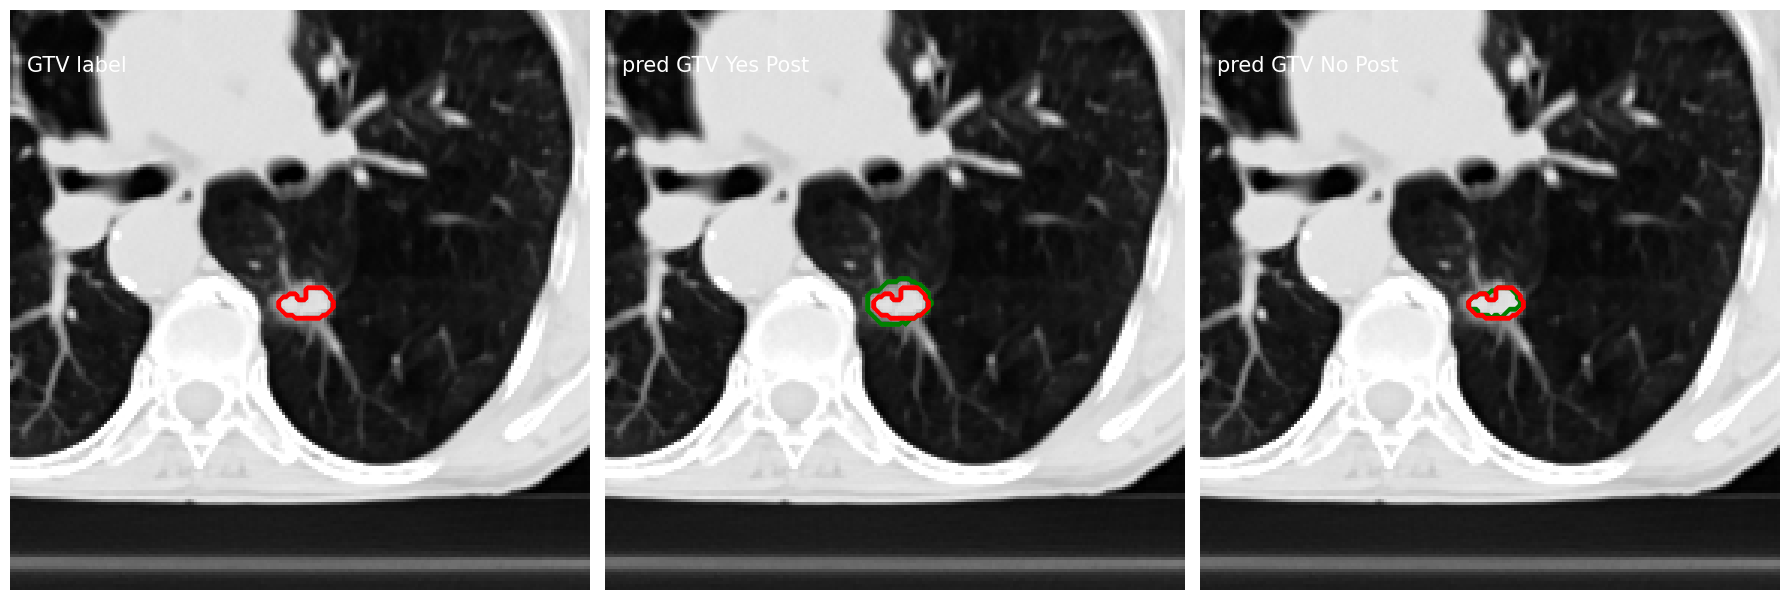

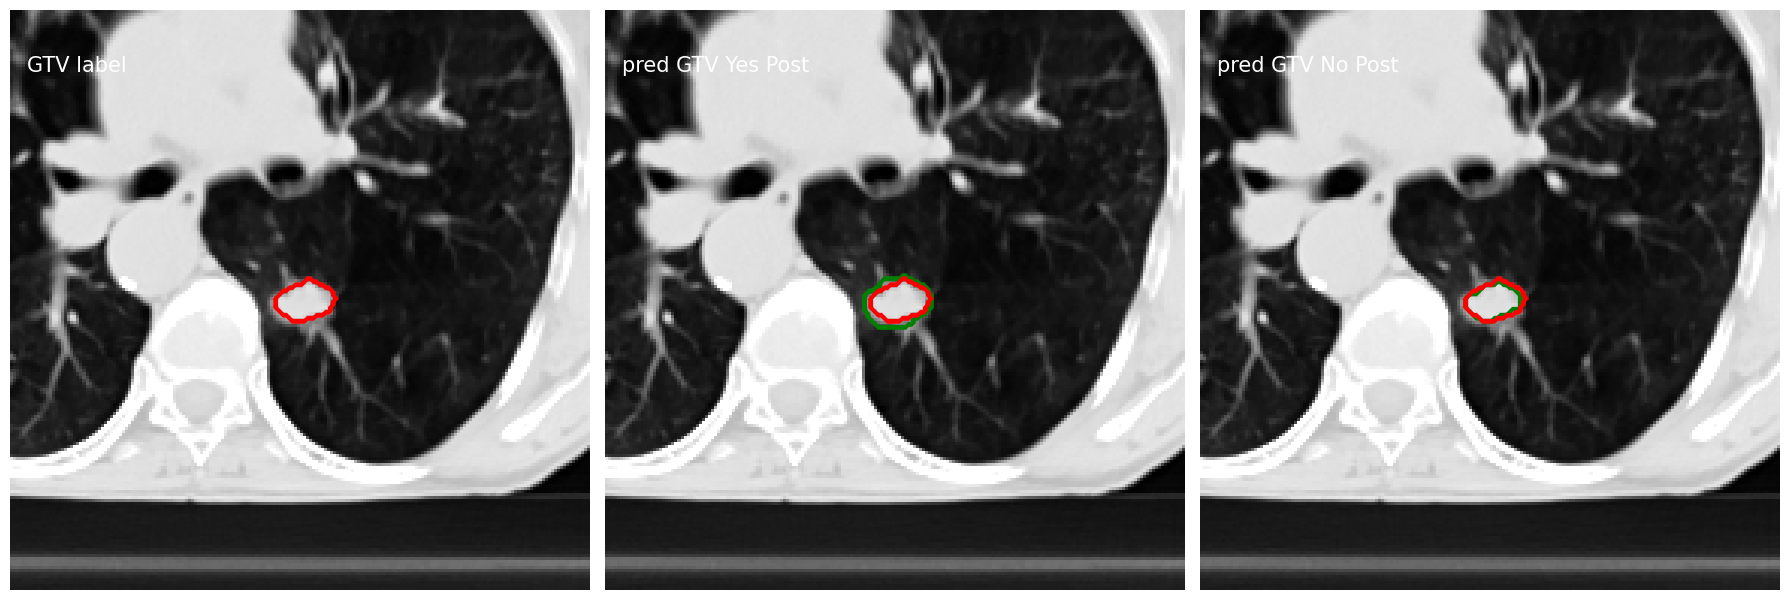

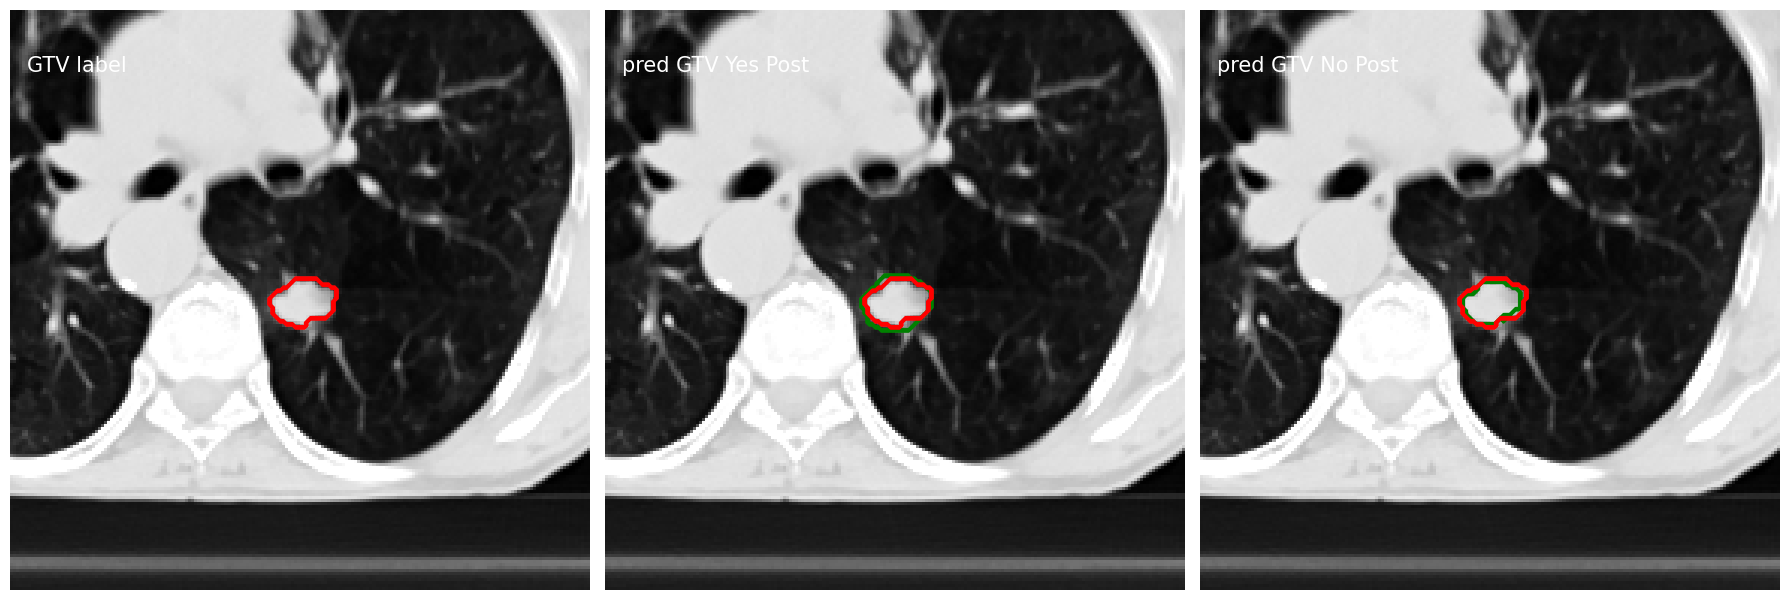

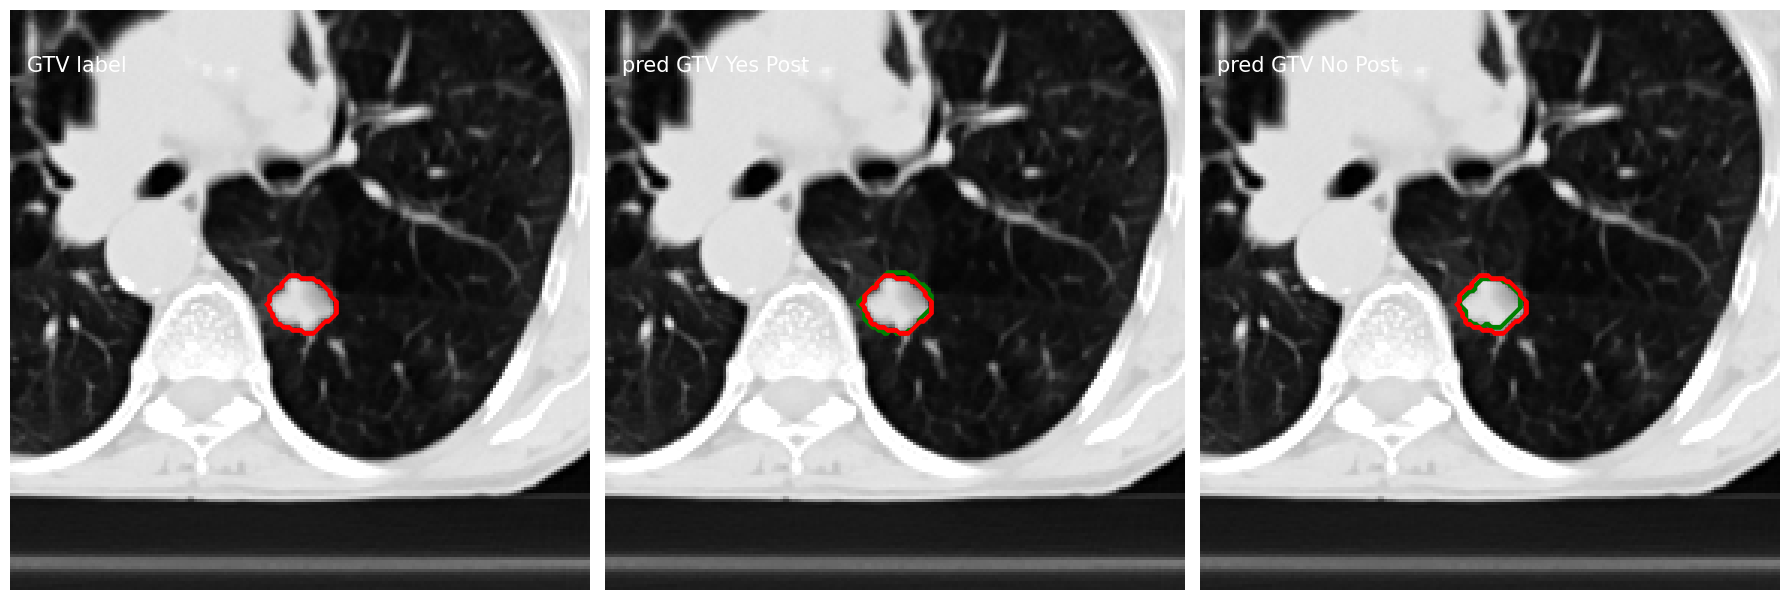

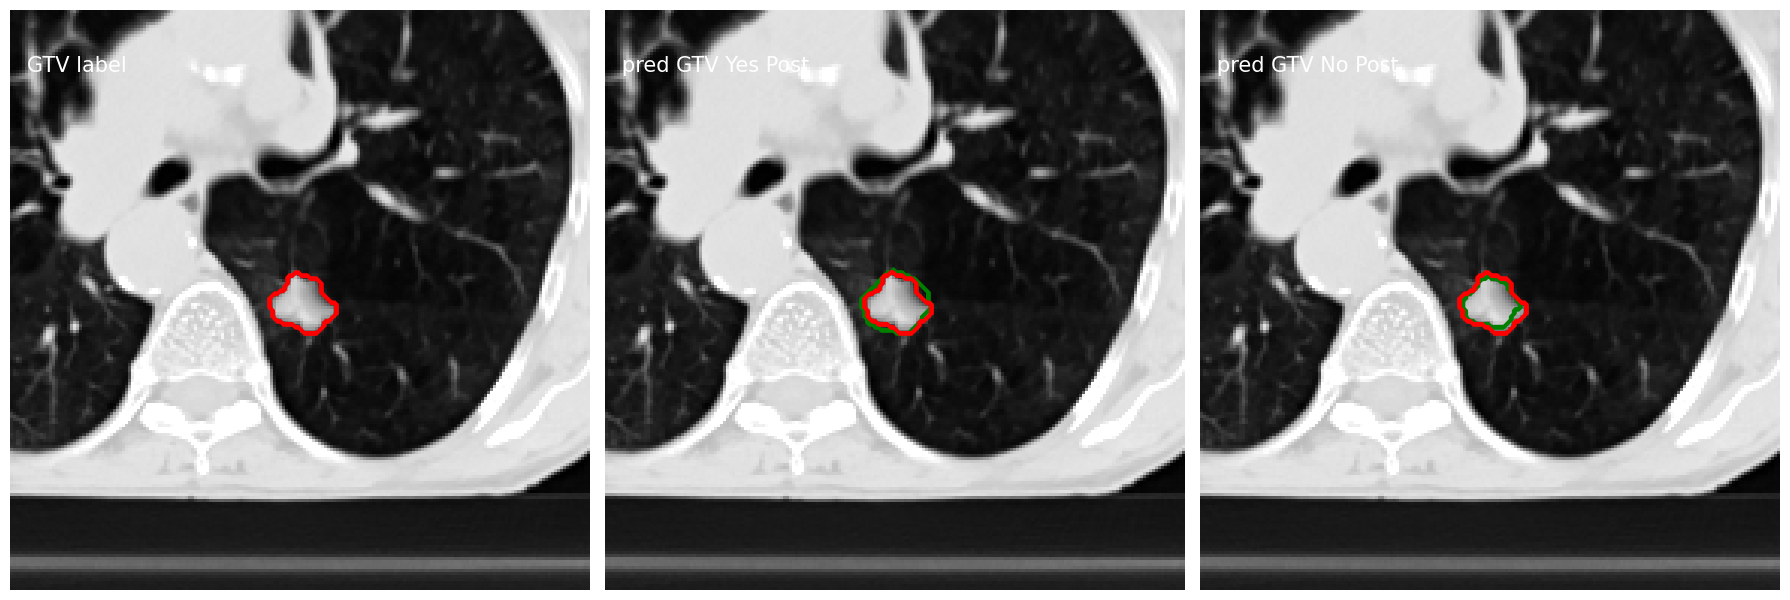

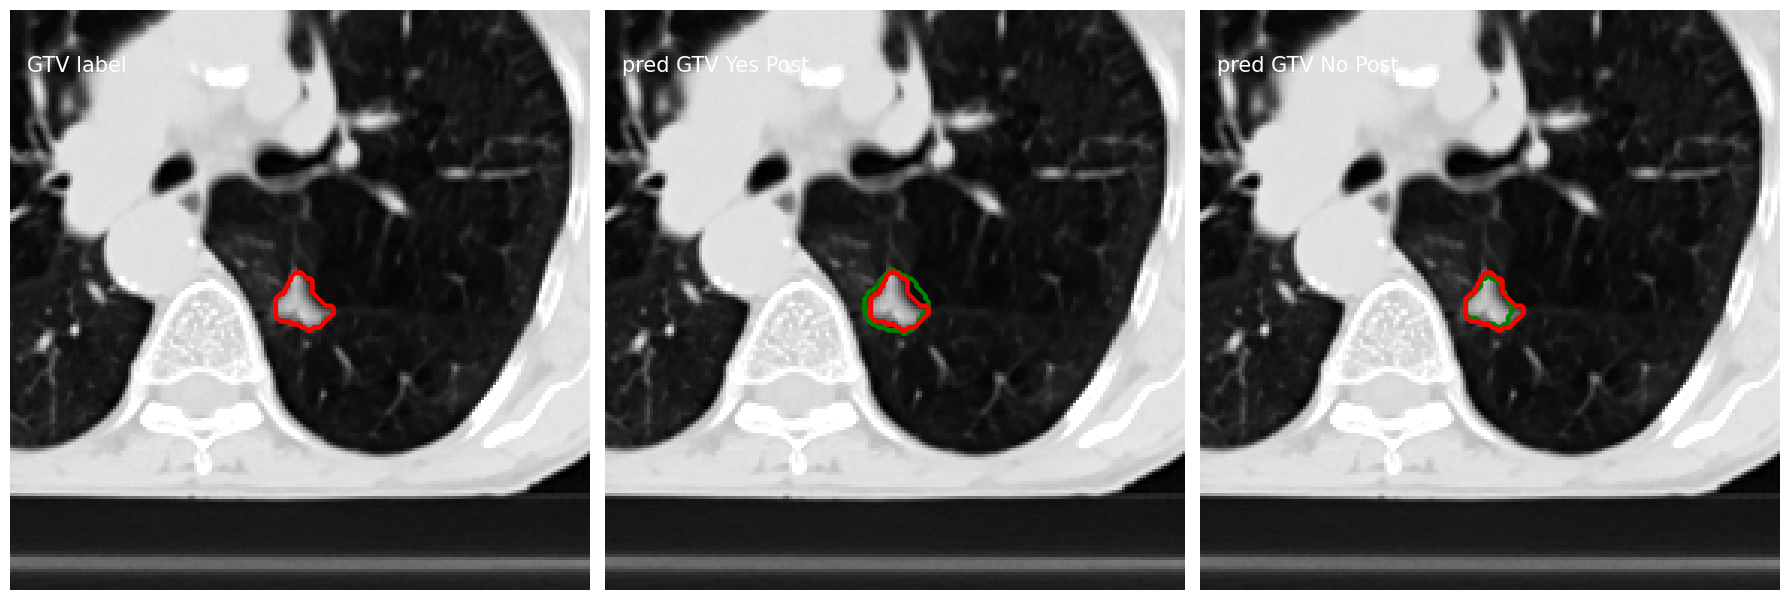

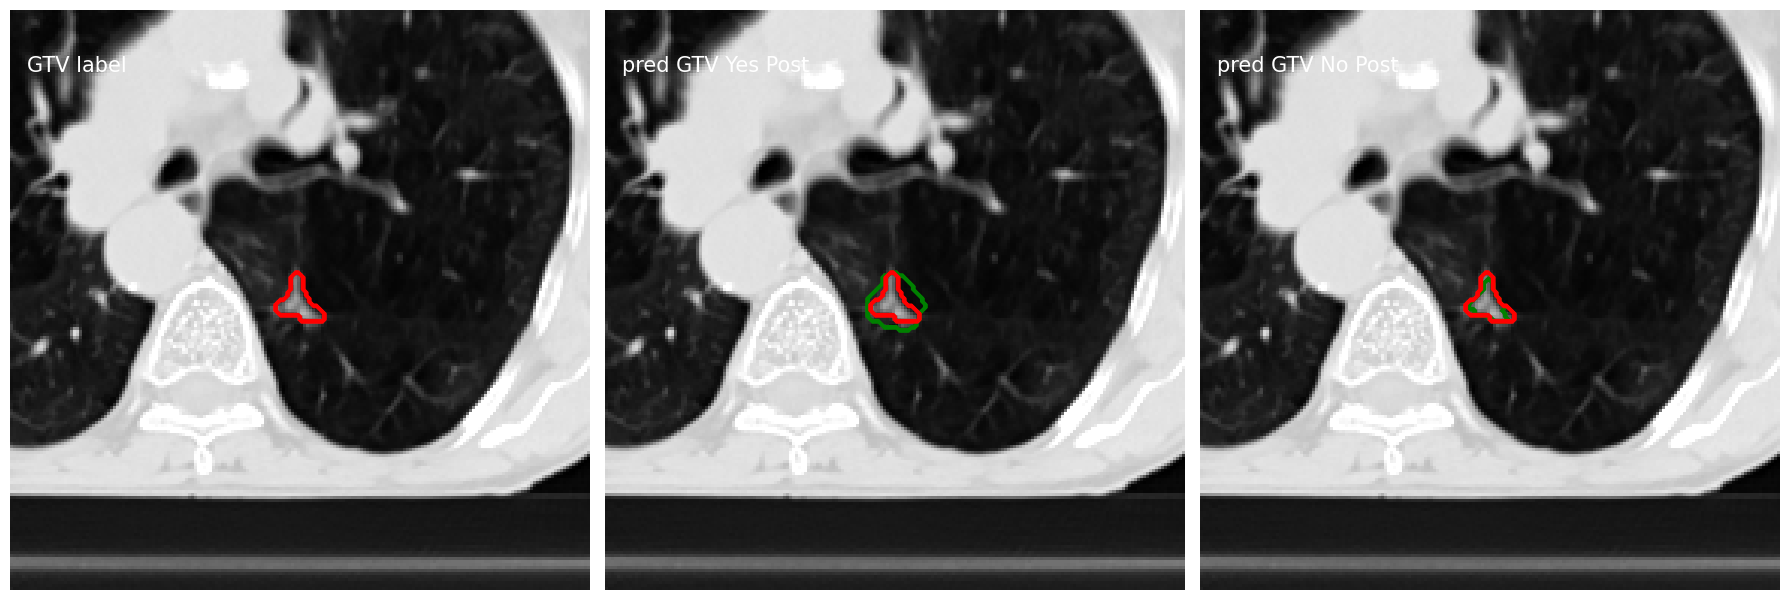

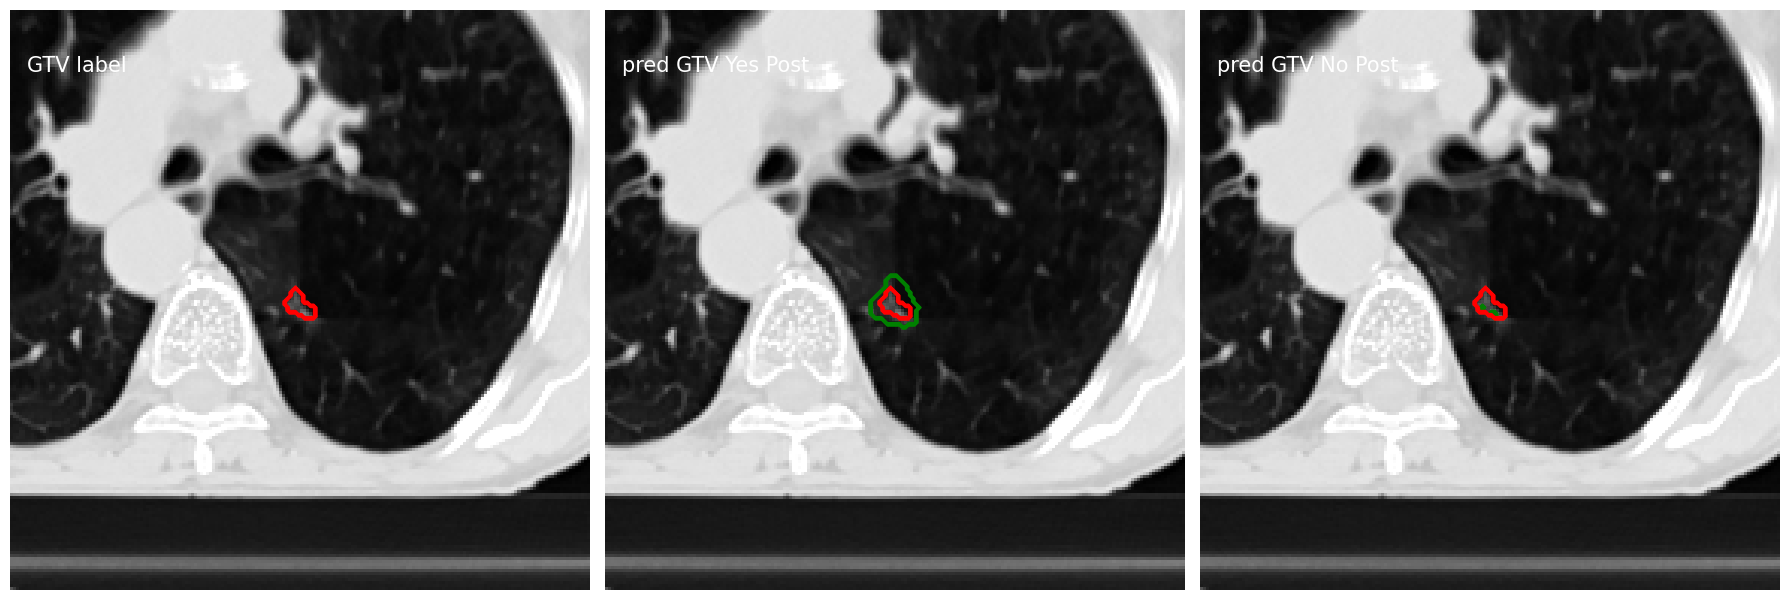

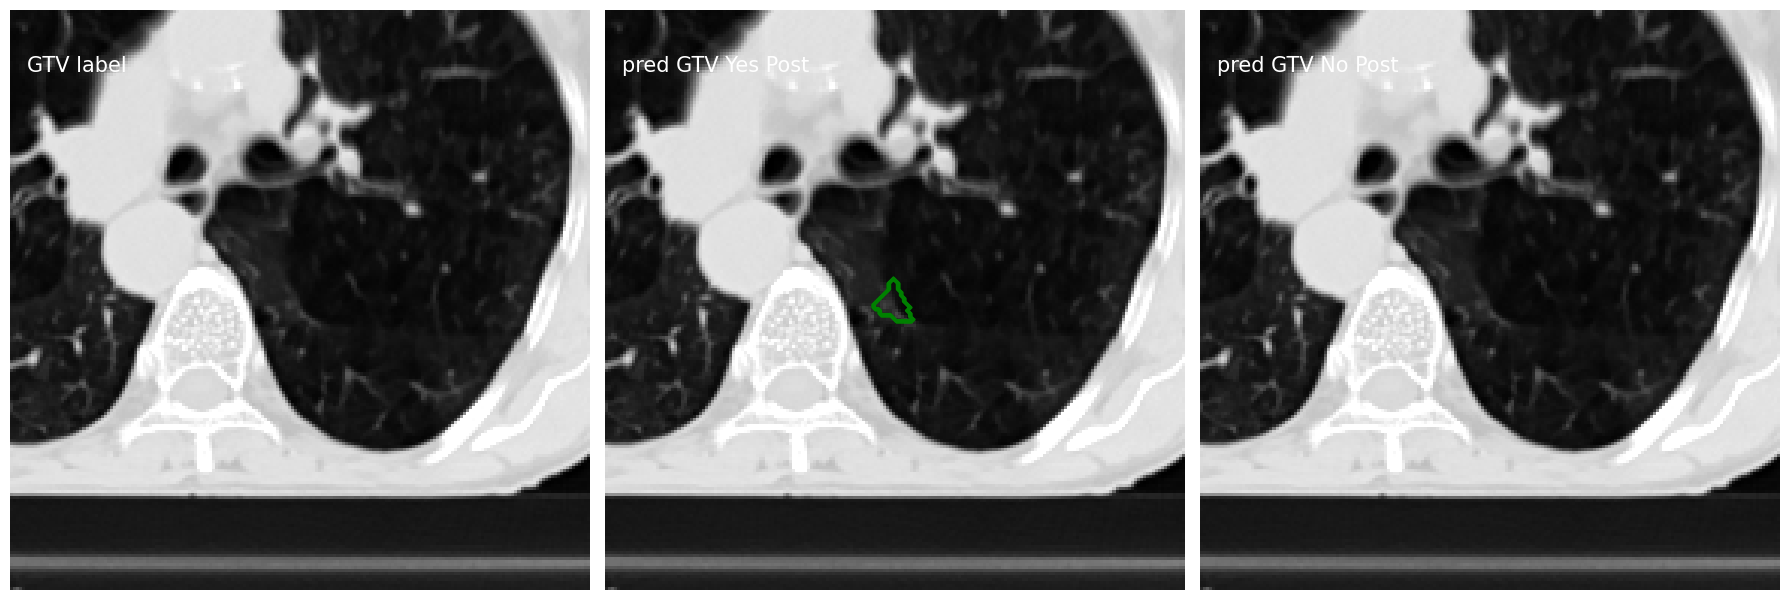

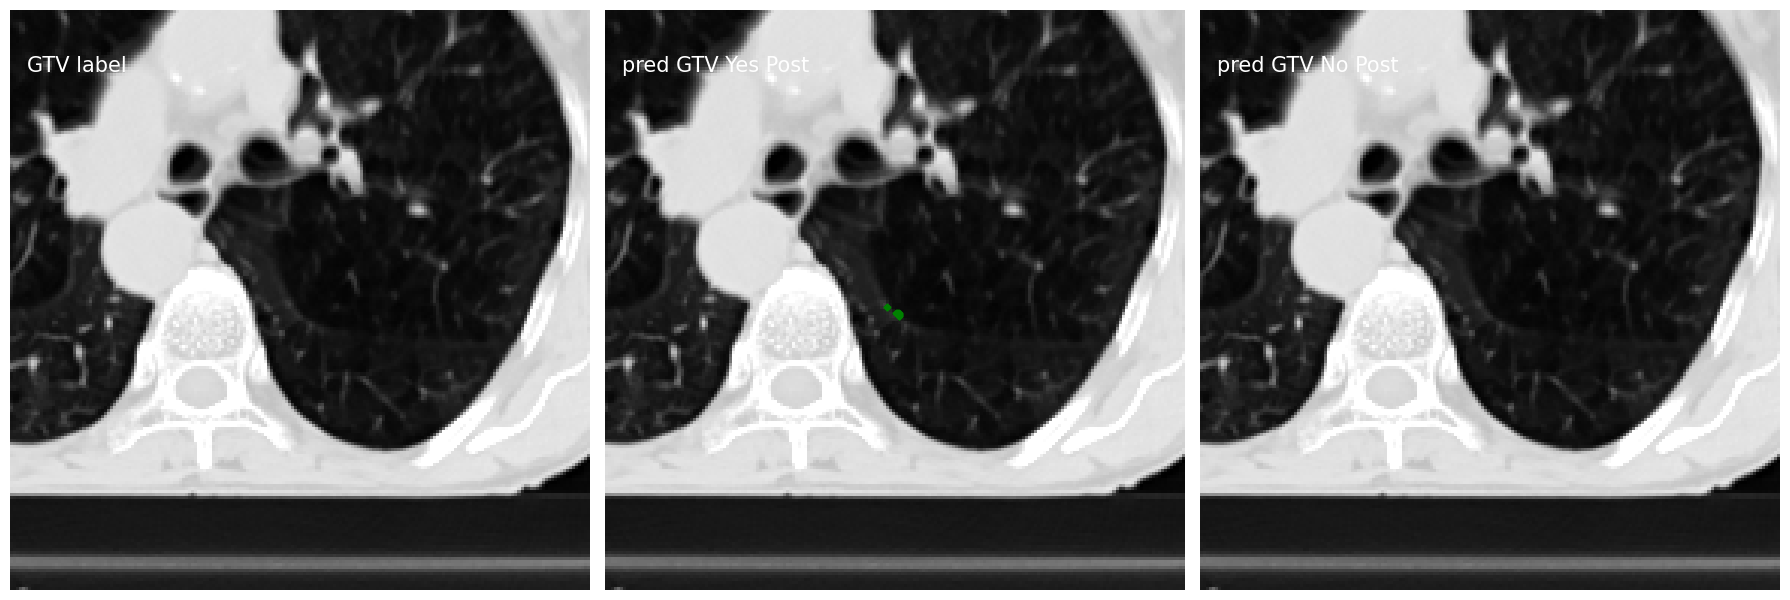

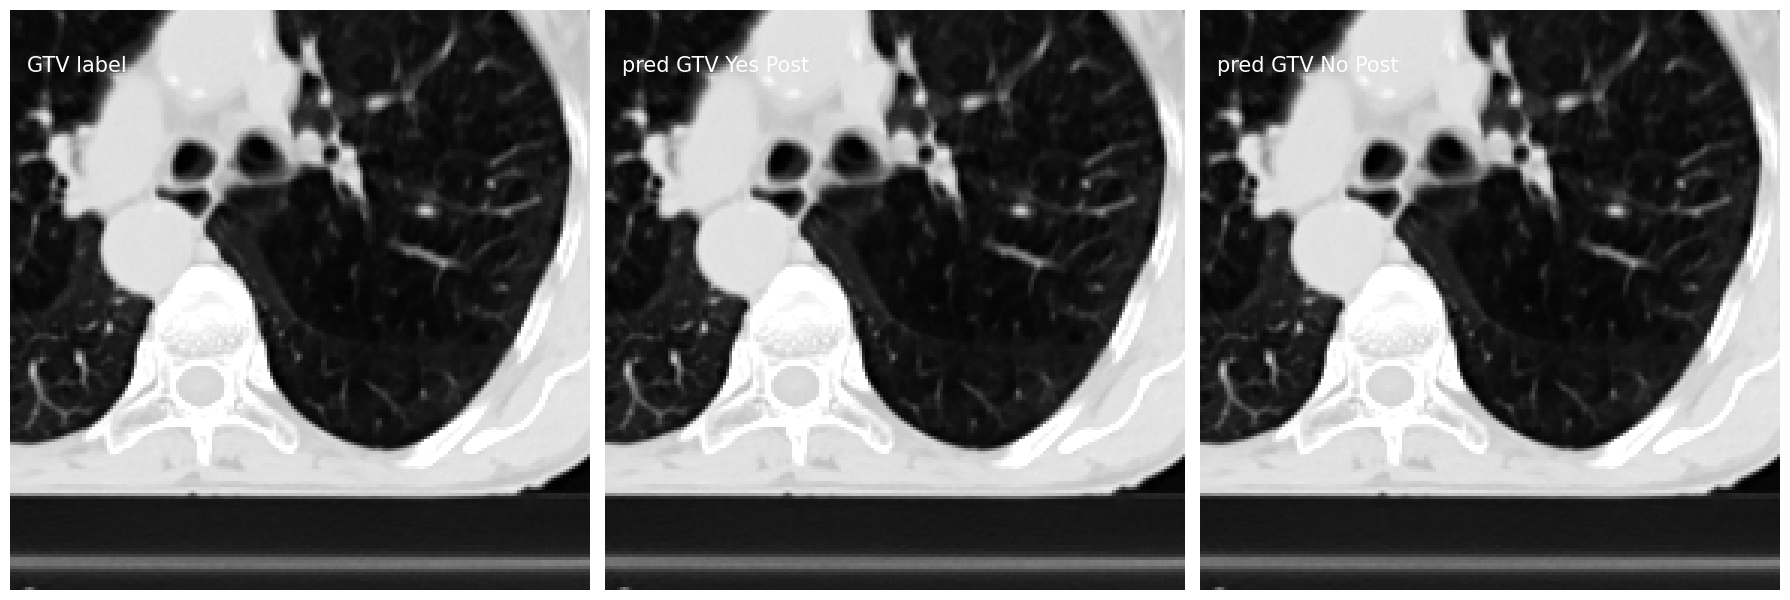

Coronal


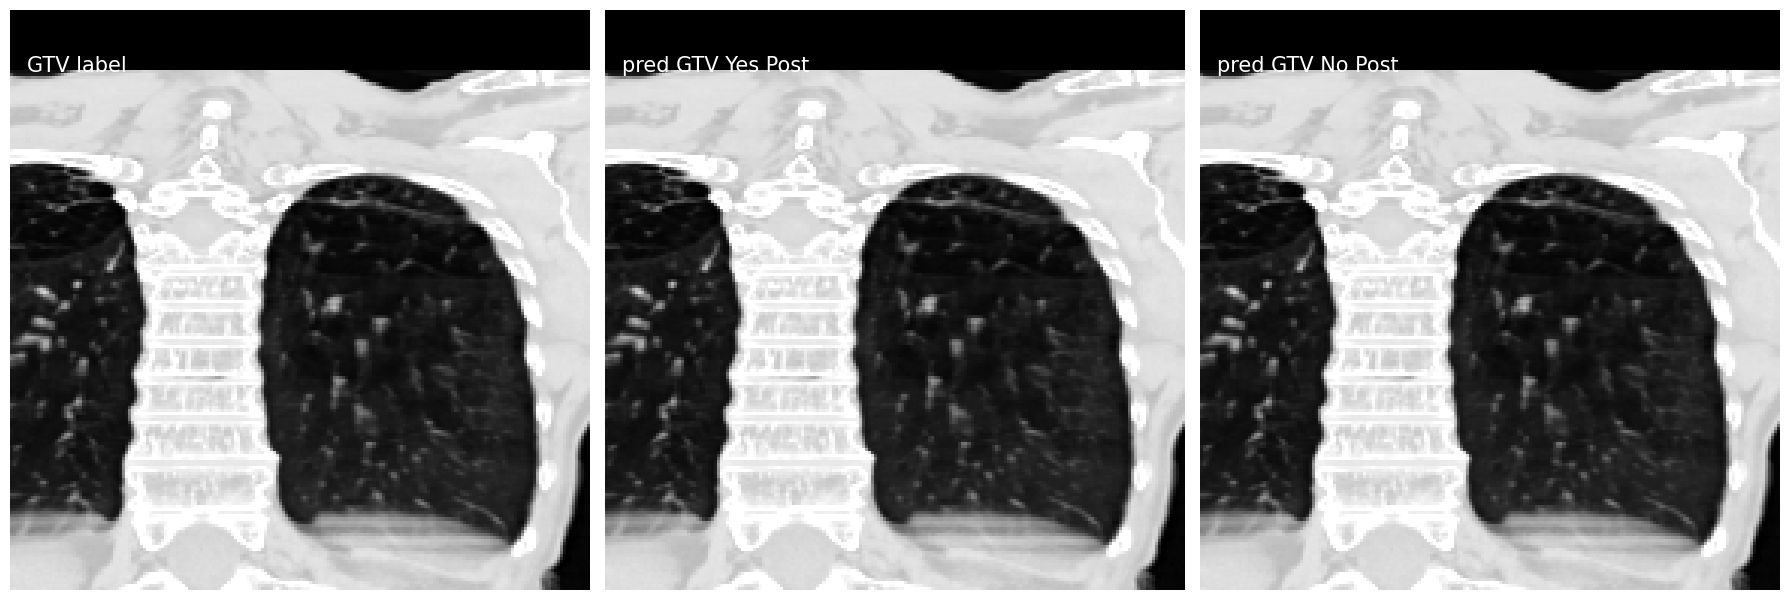

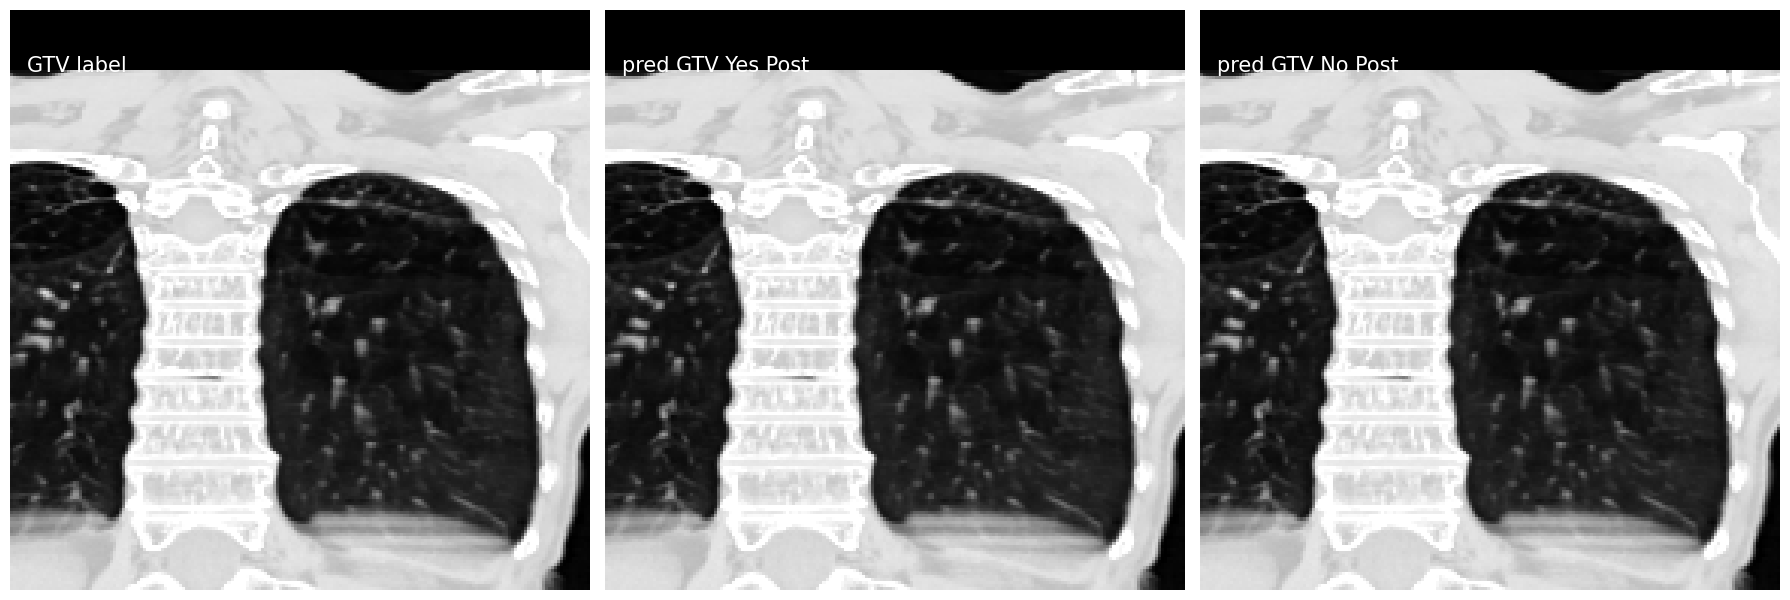

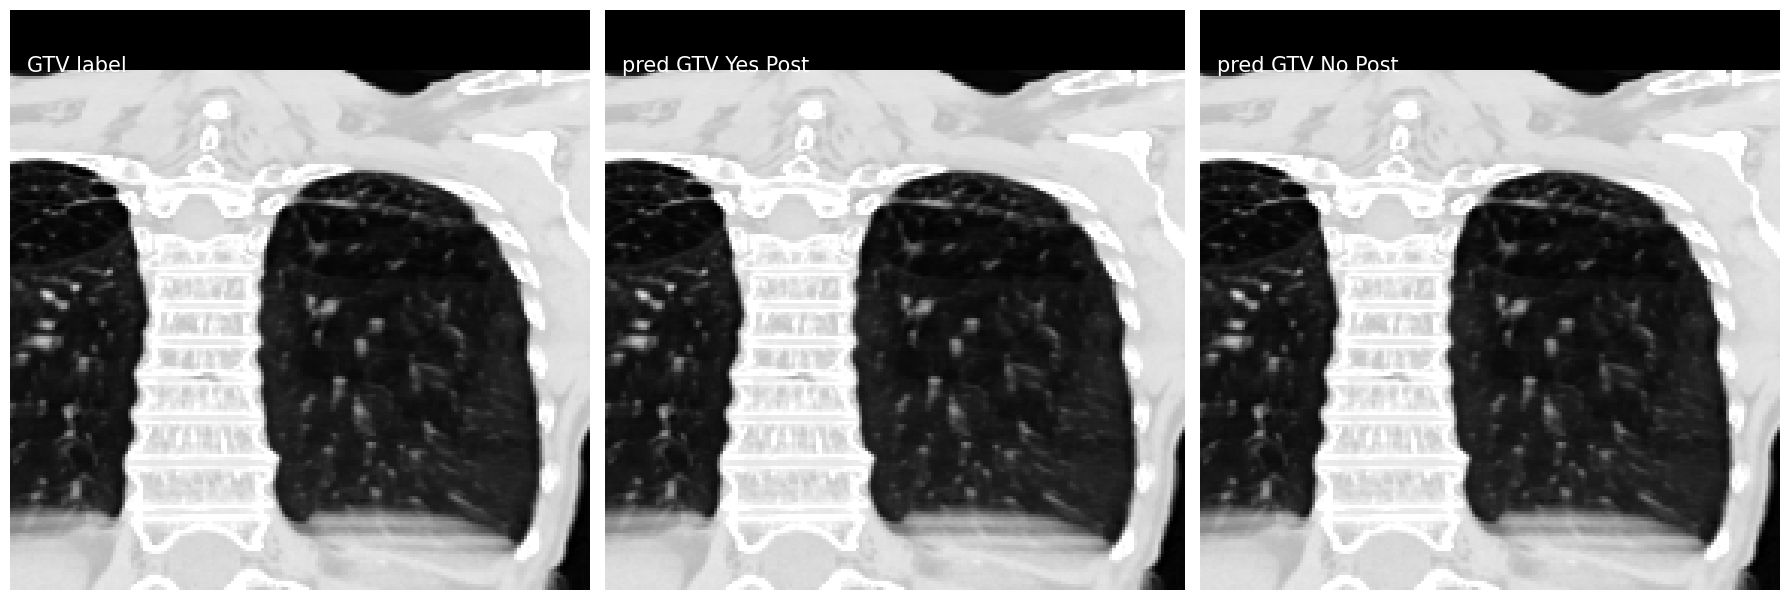

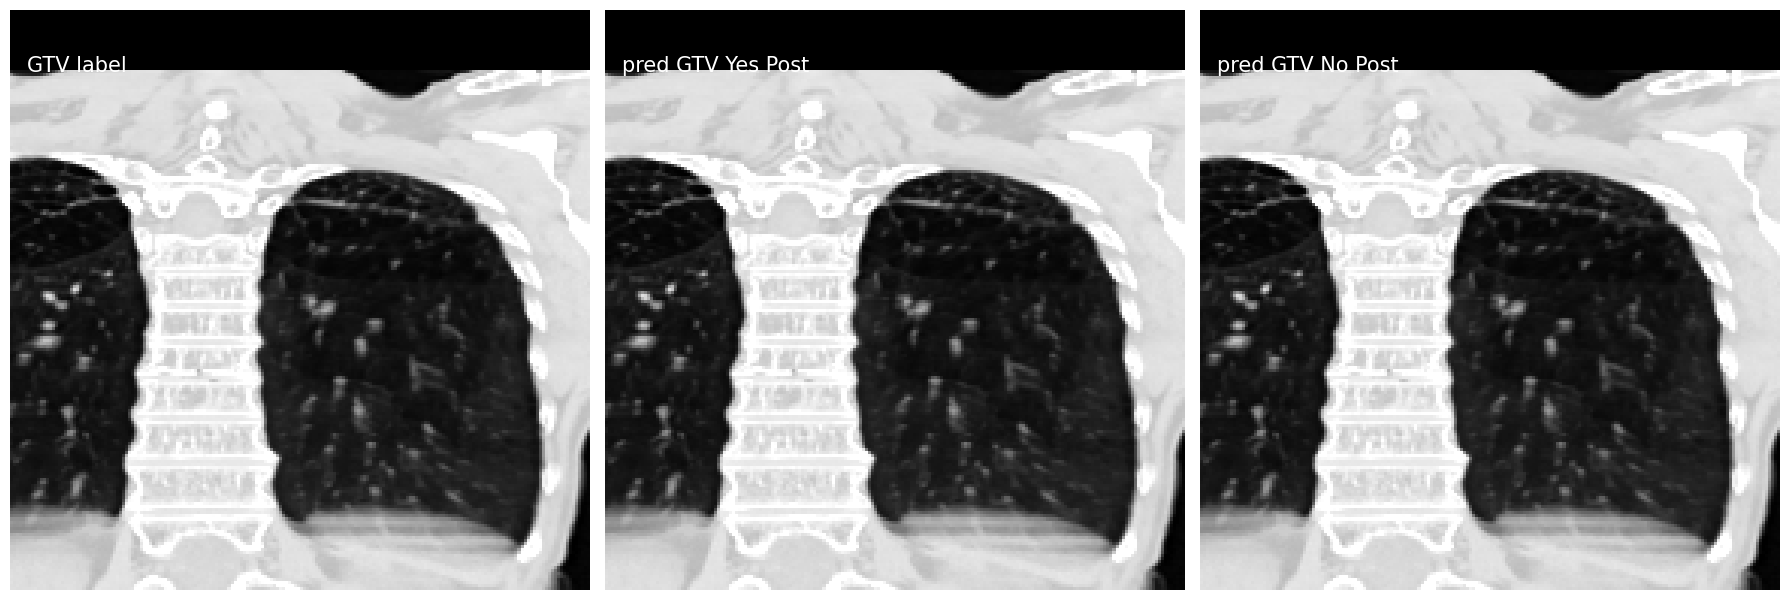

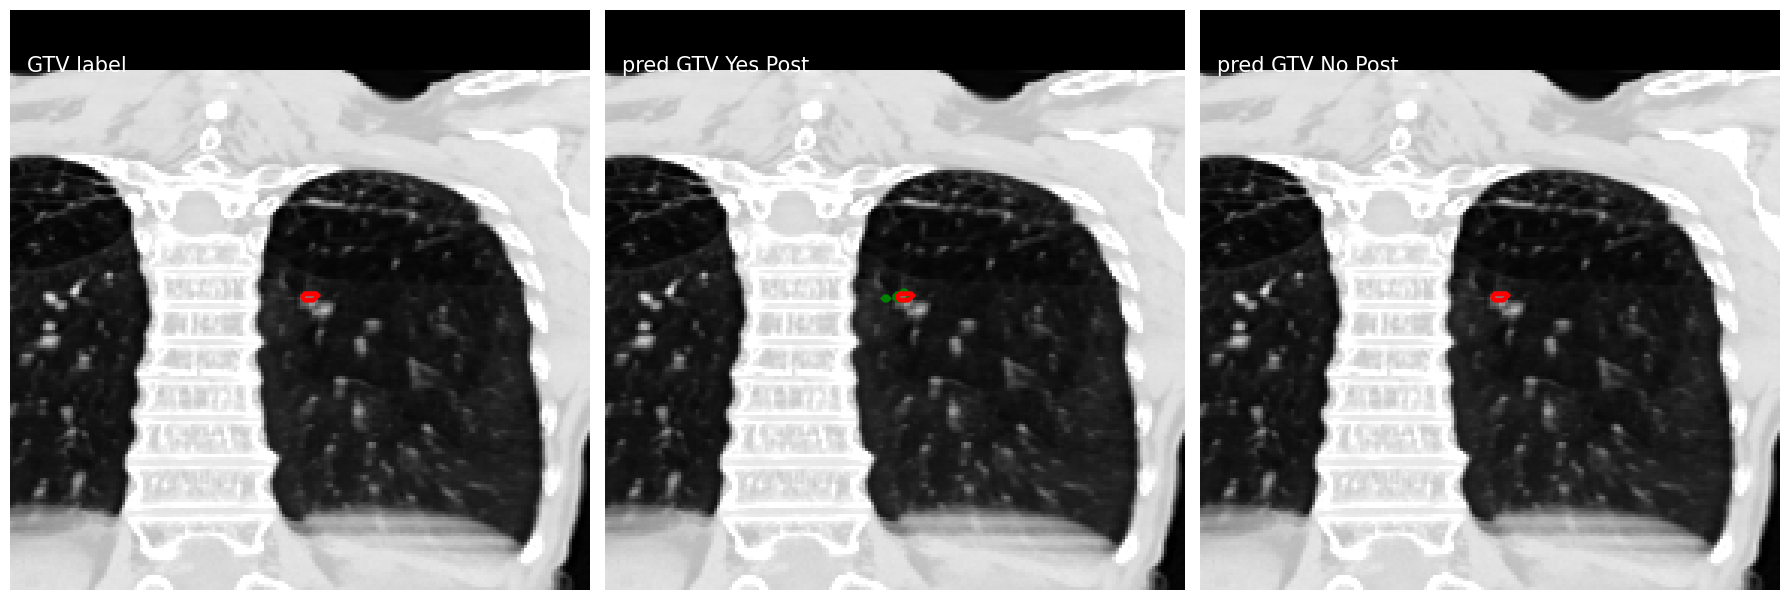

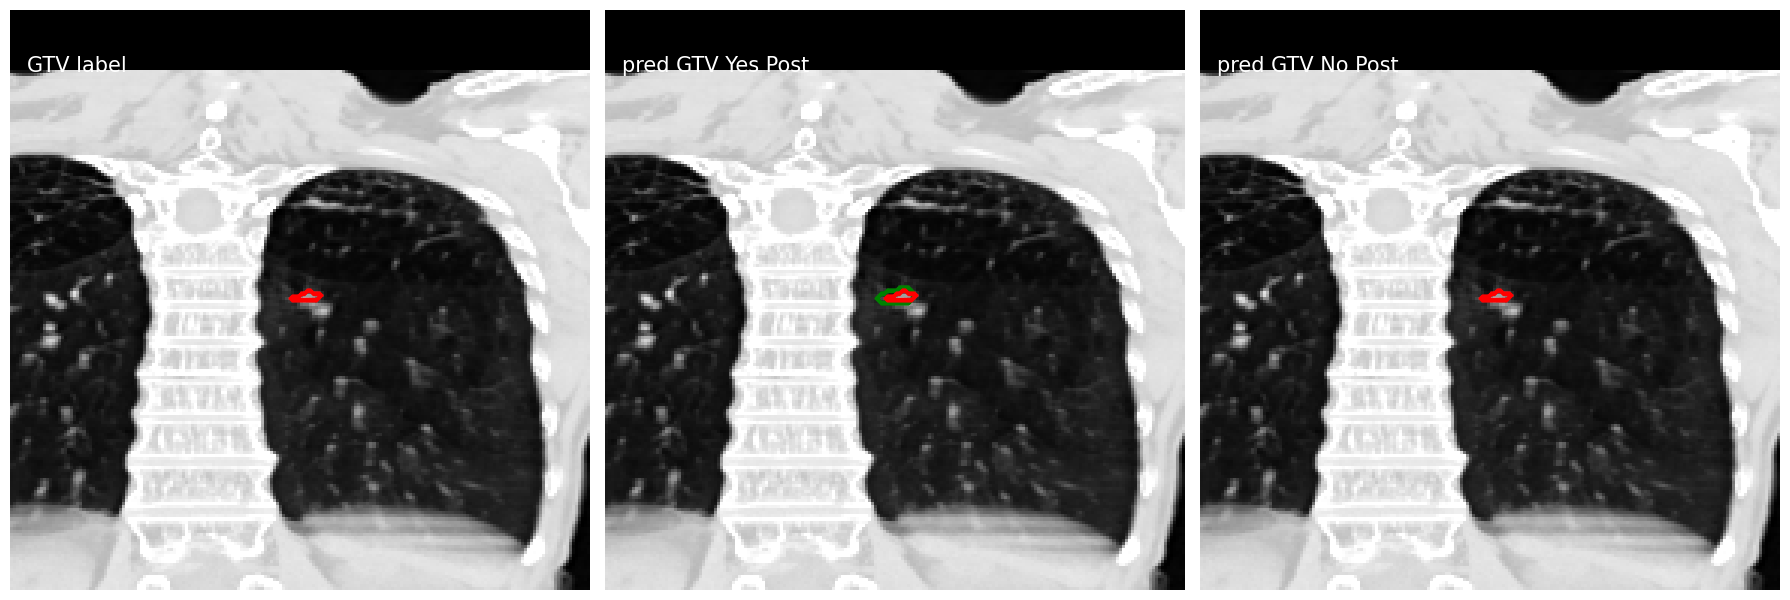

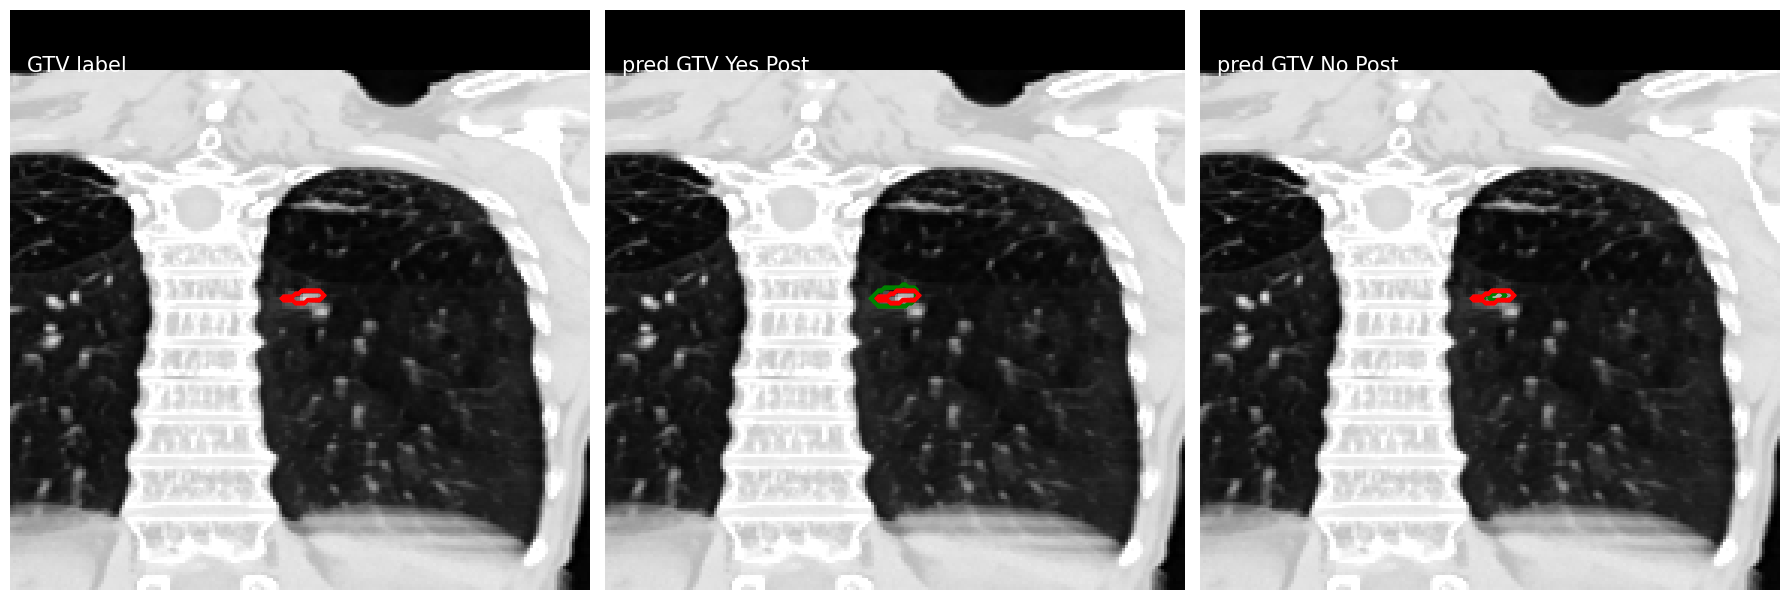

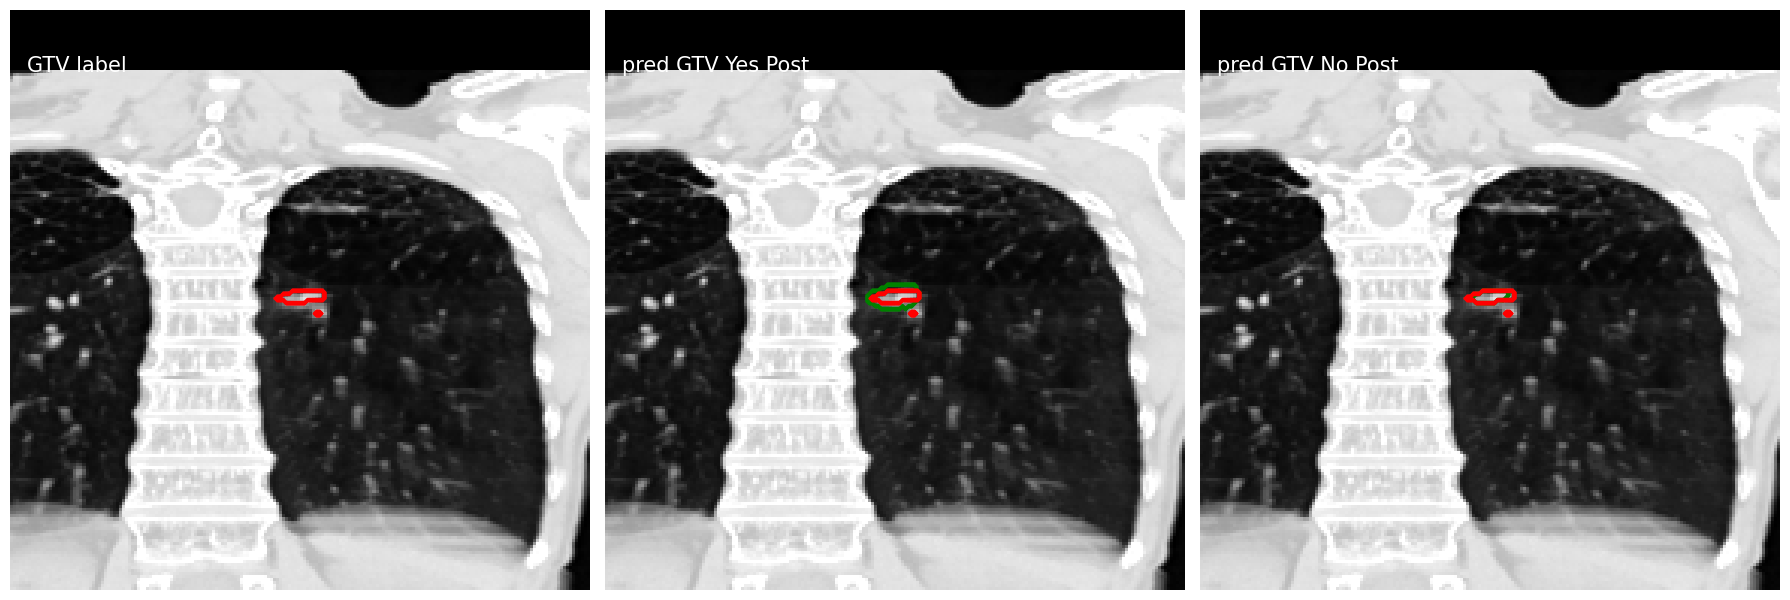

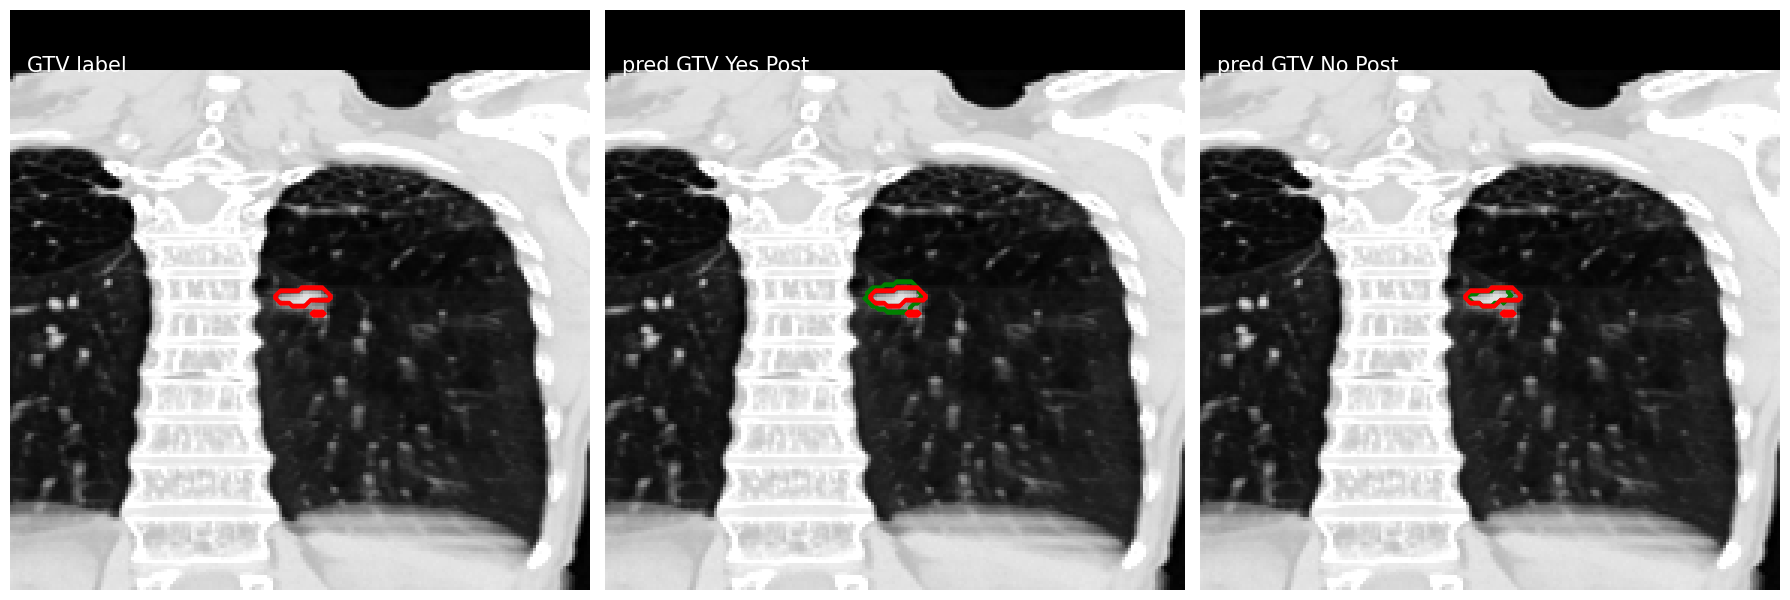

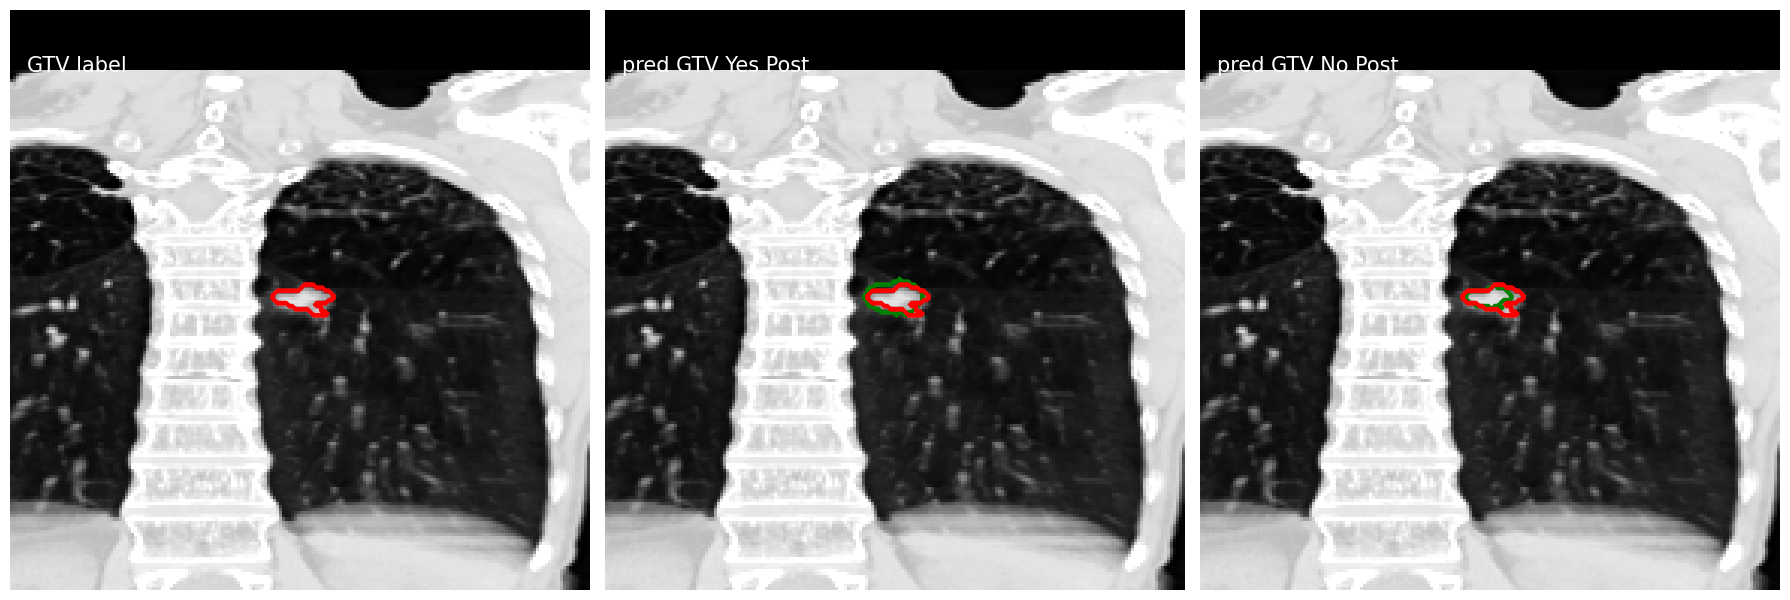

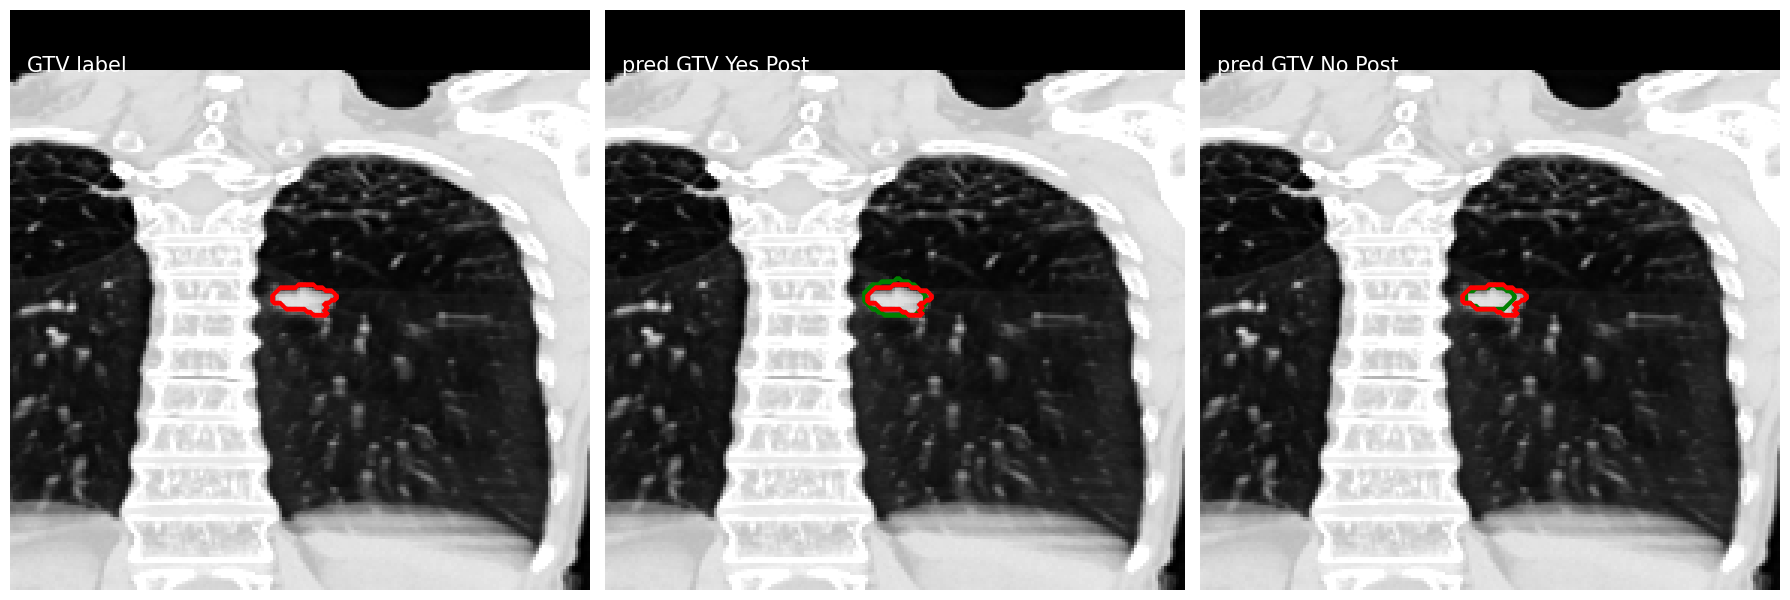

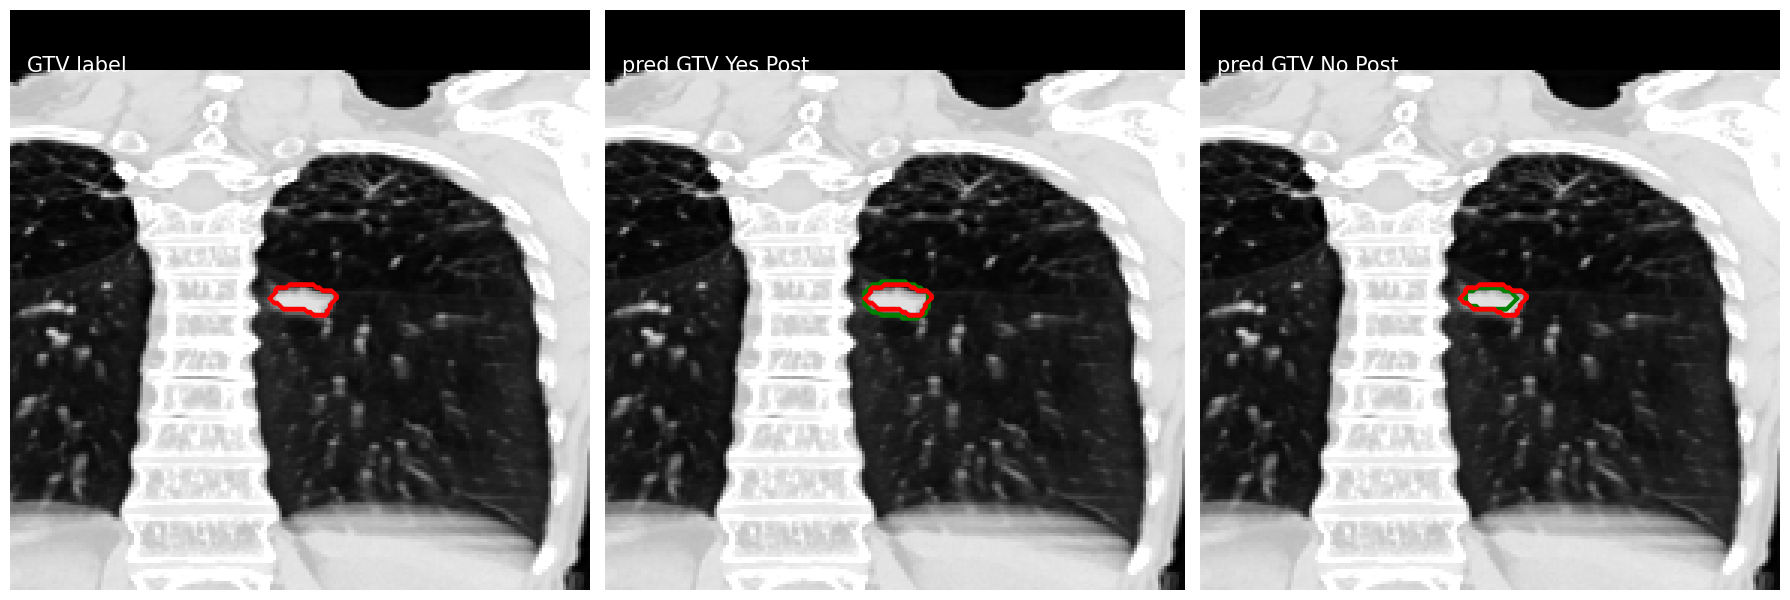

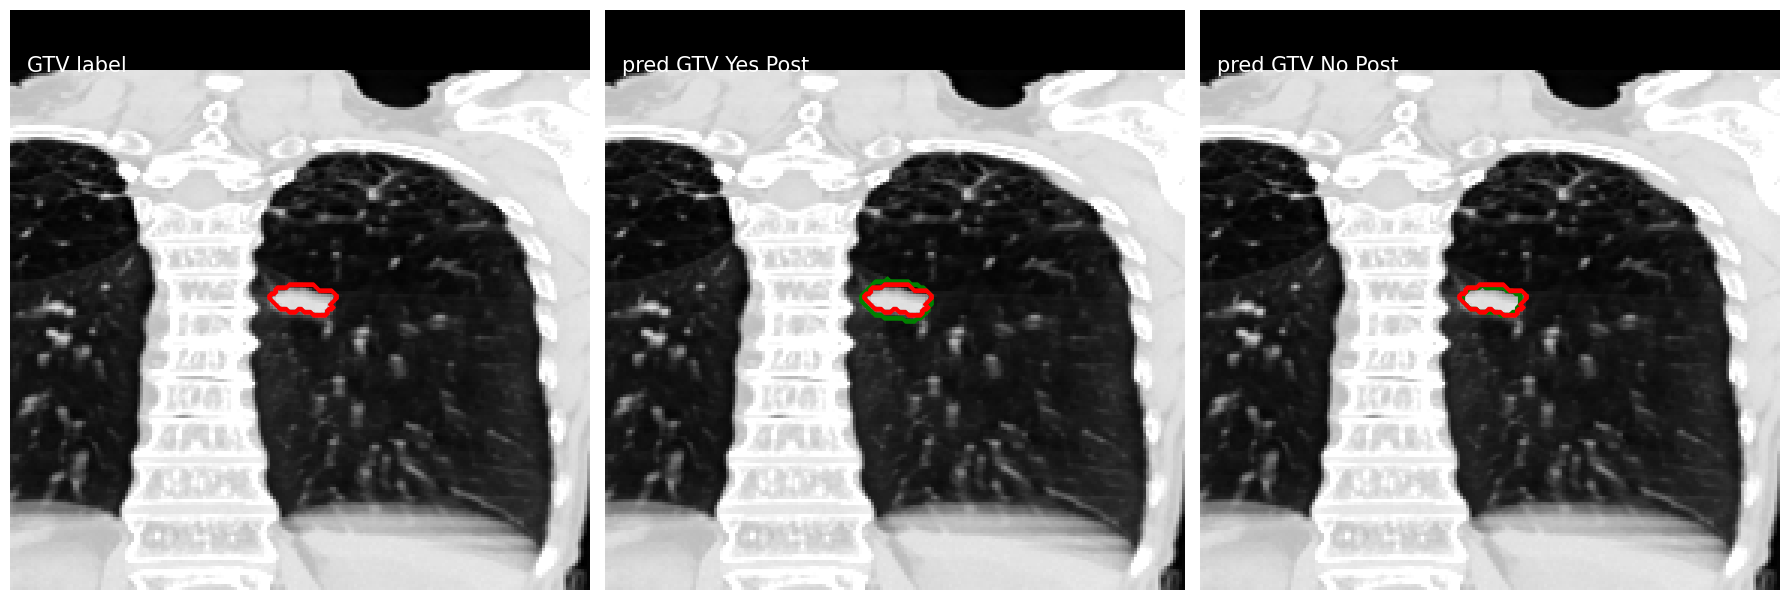

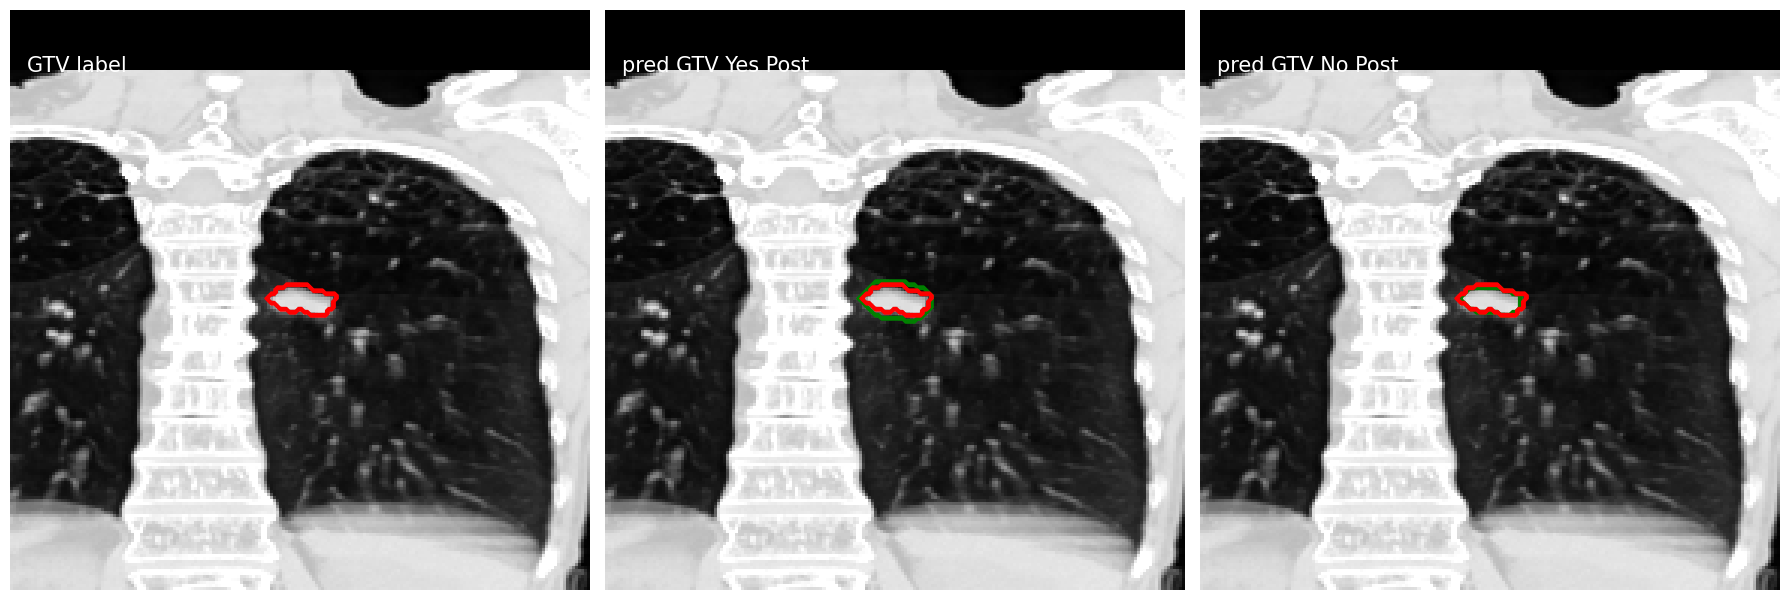

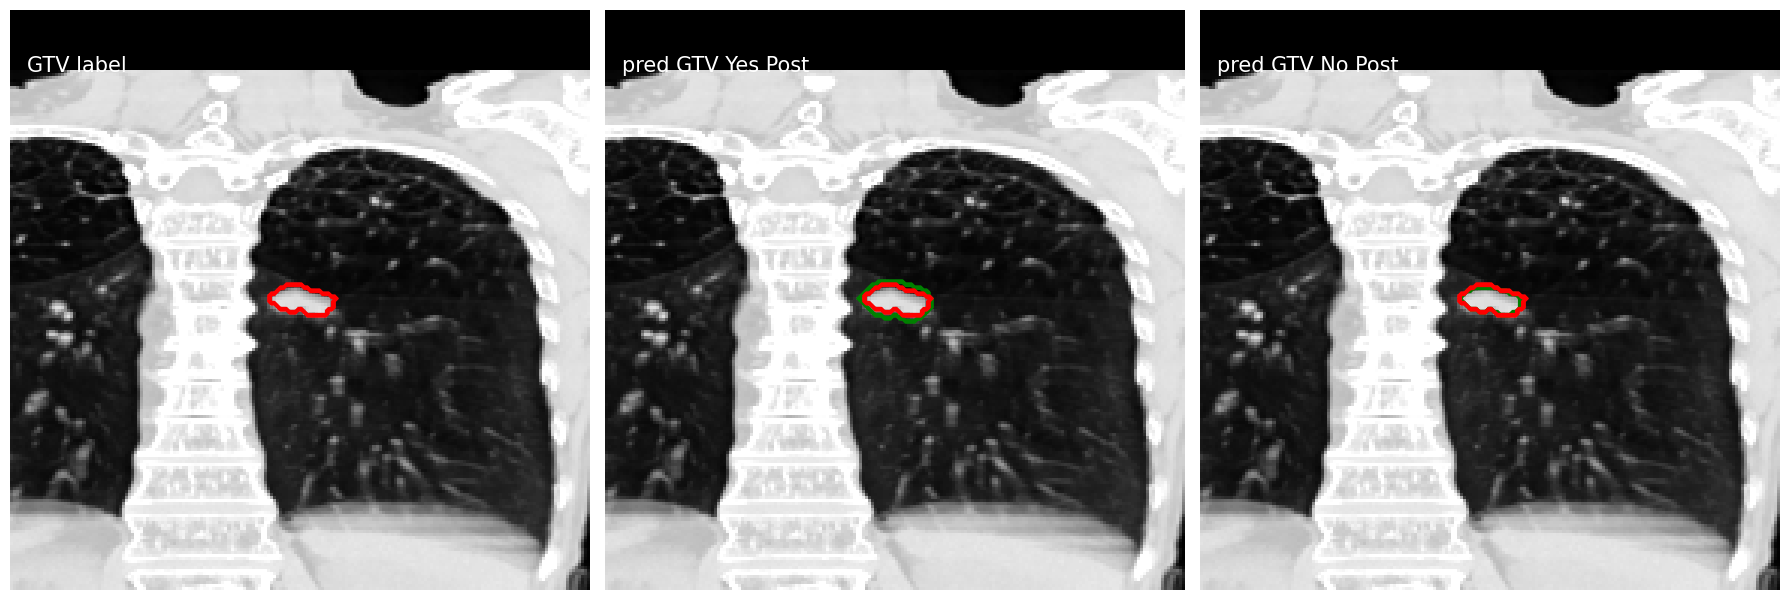

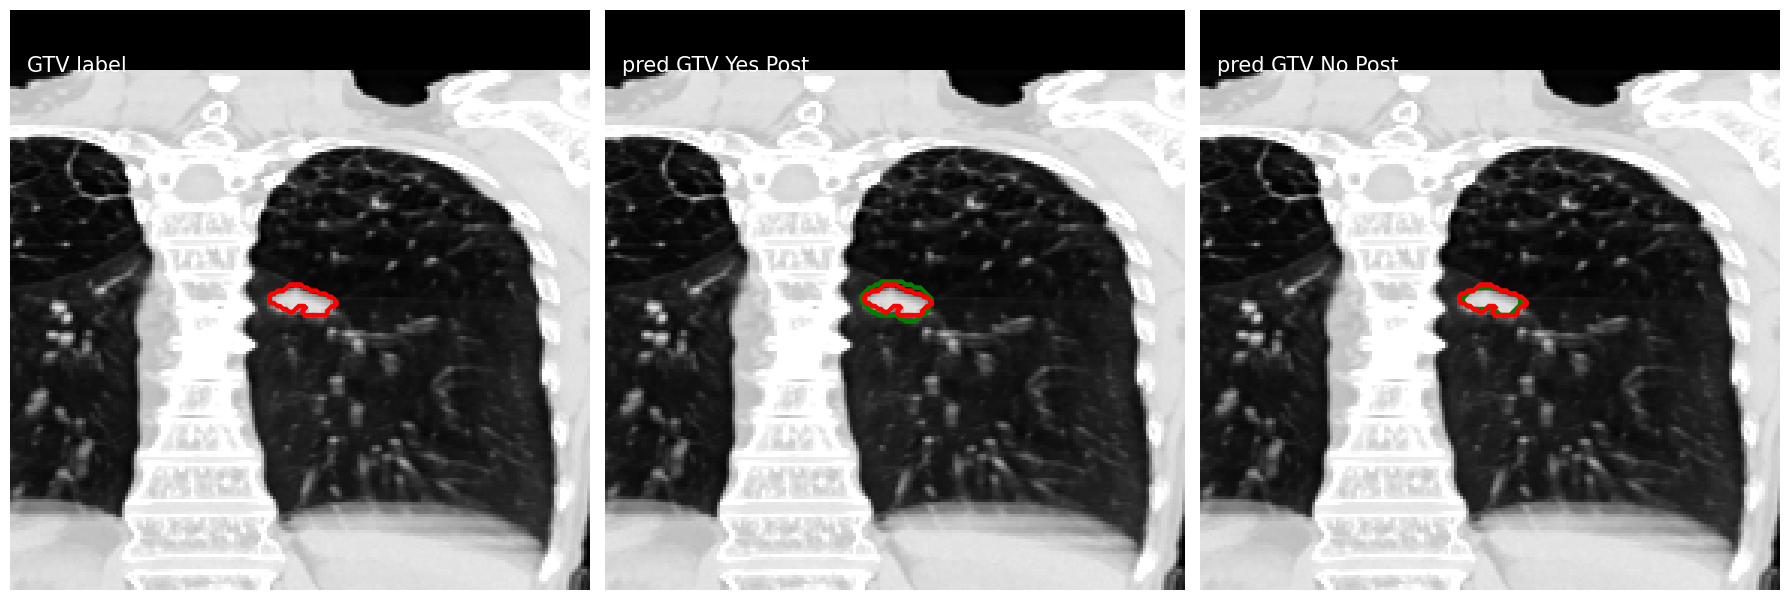

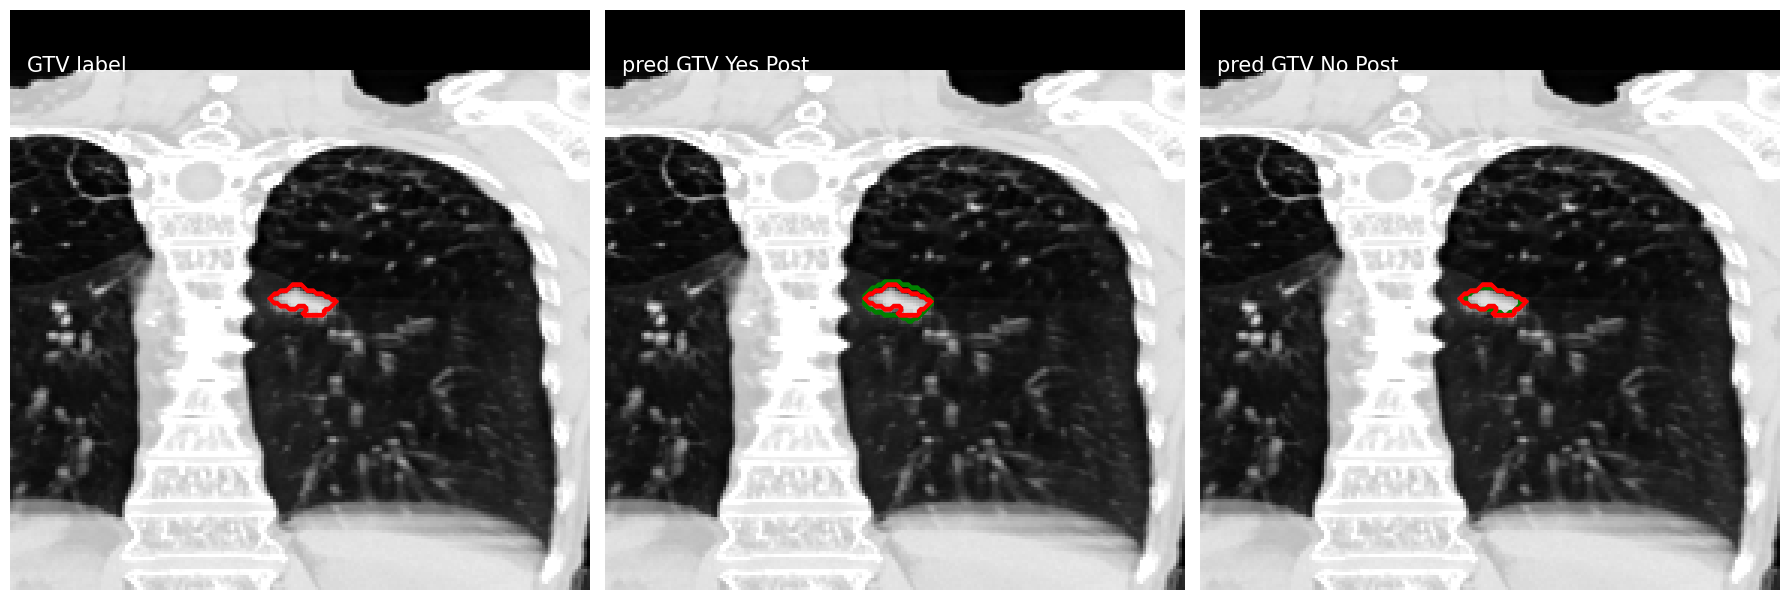

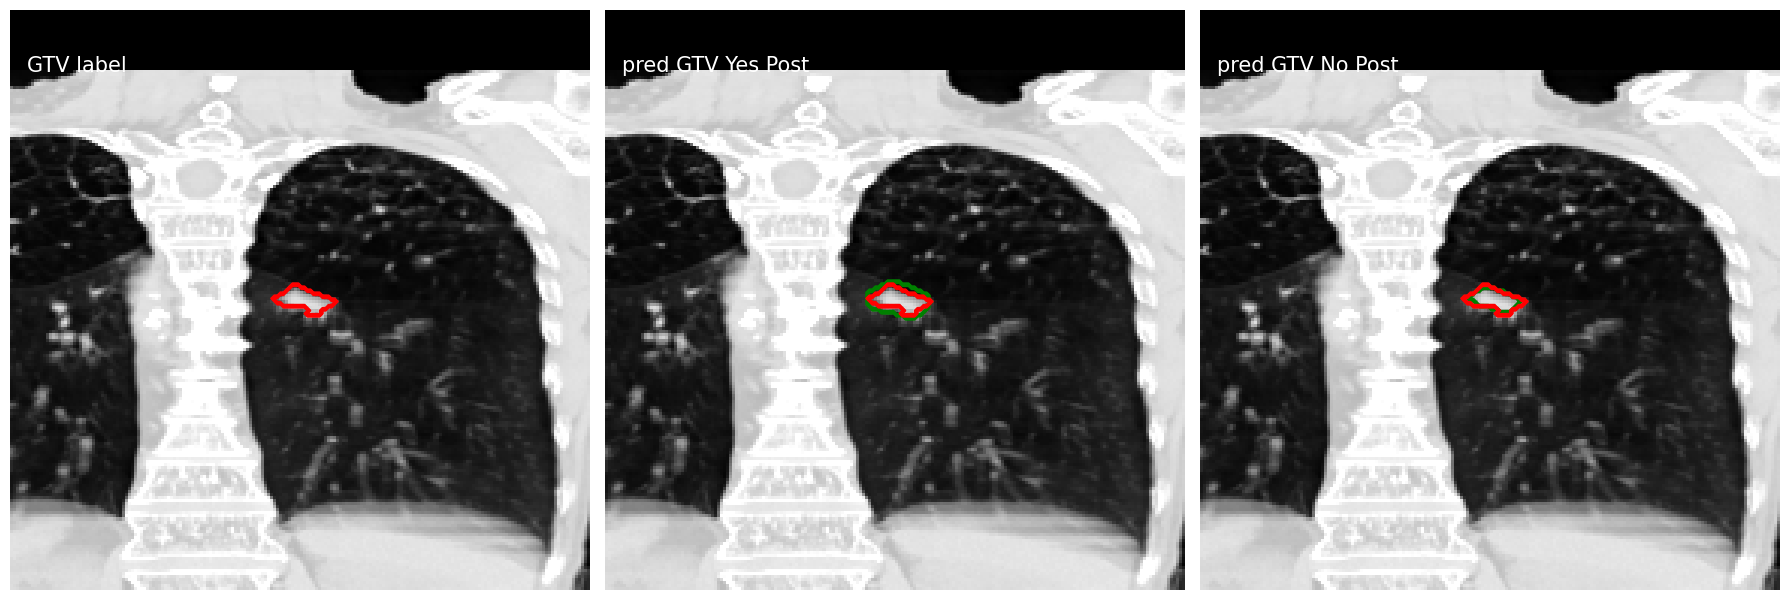

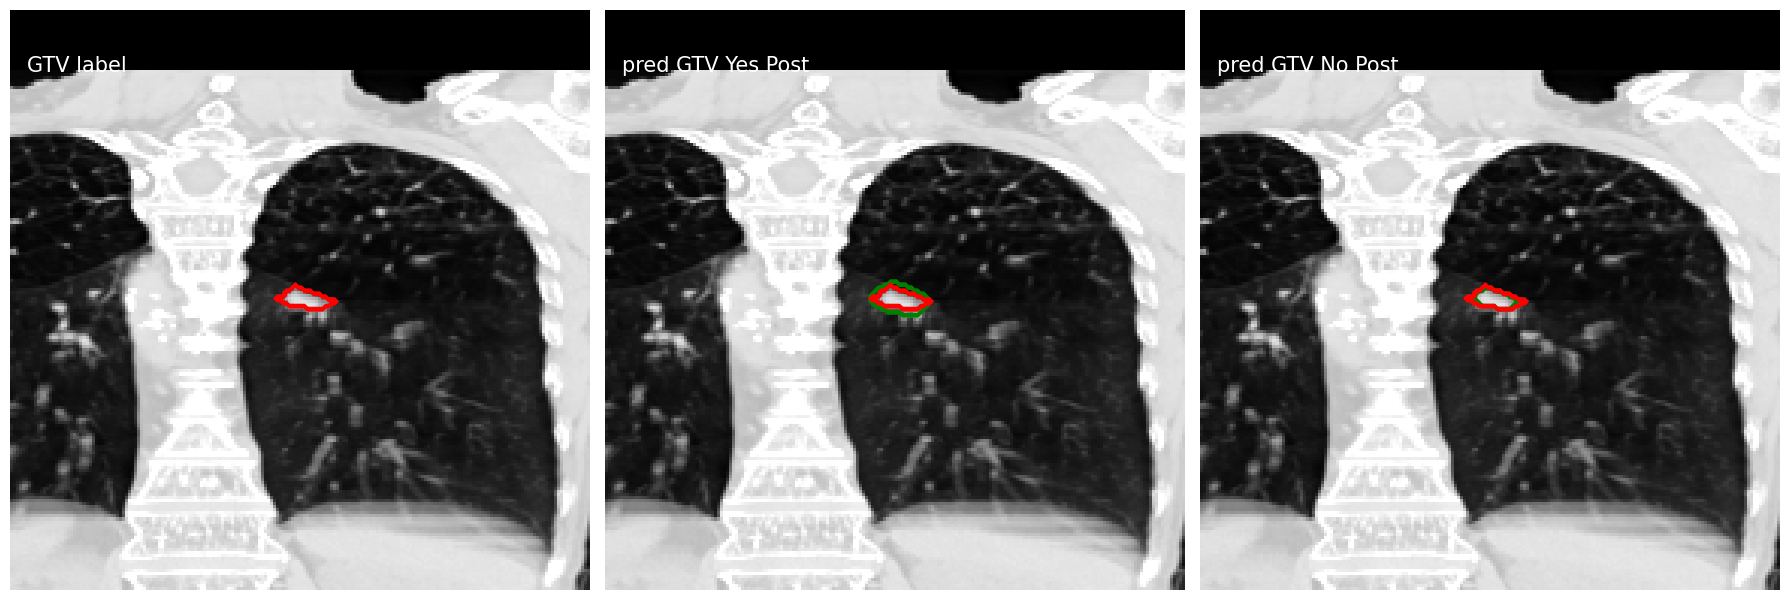

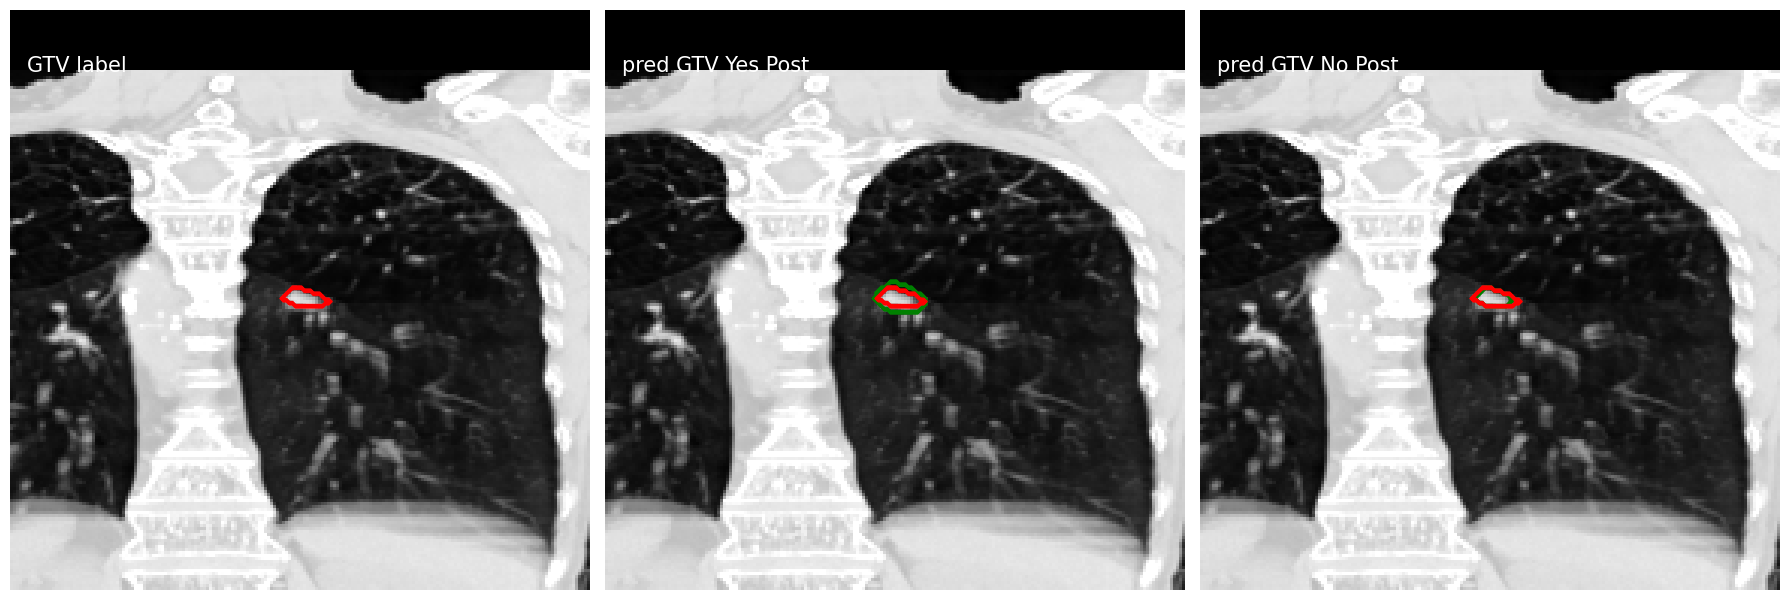

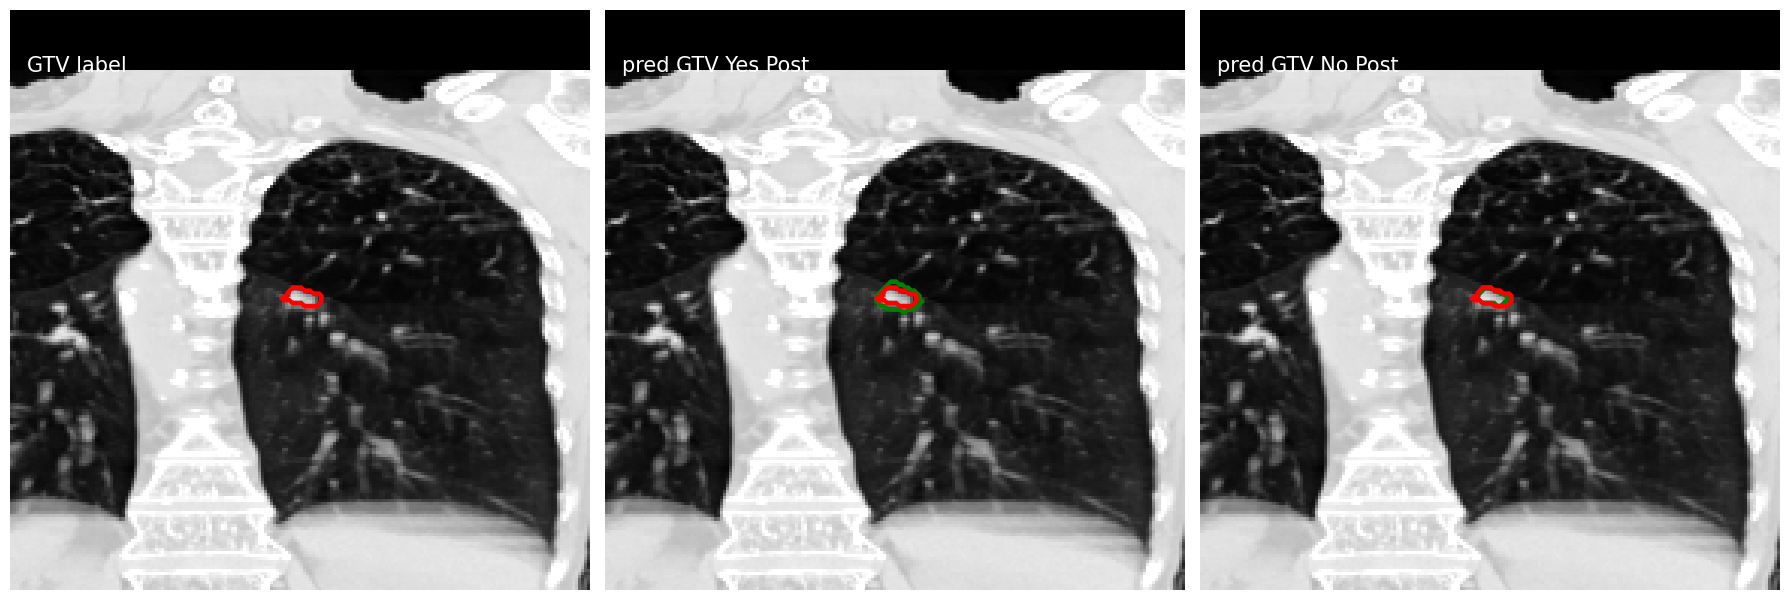

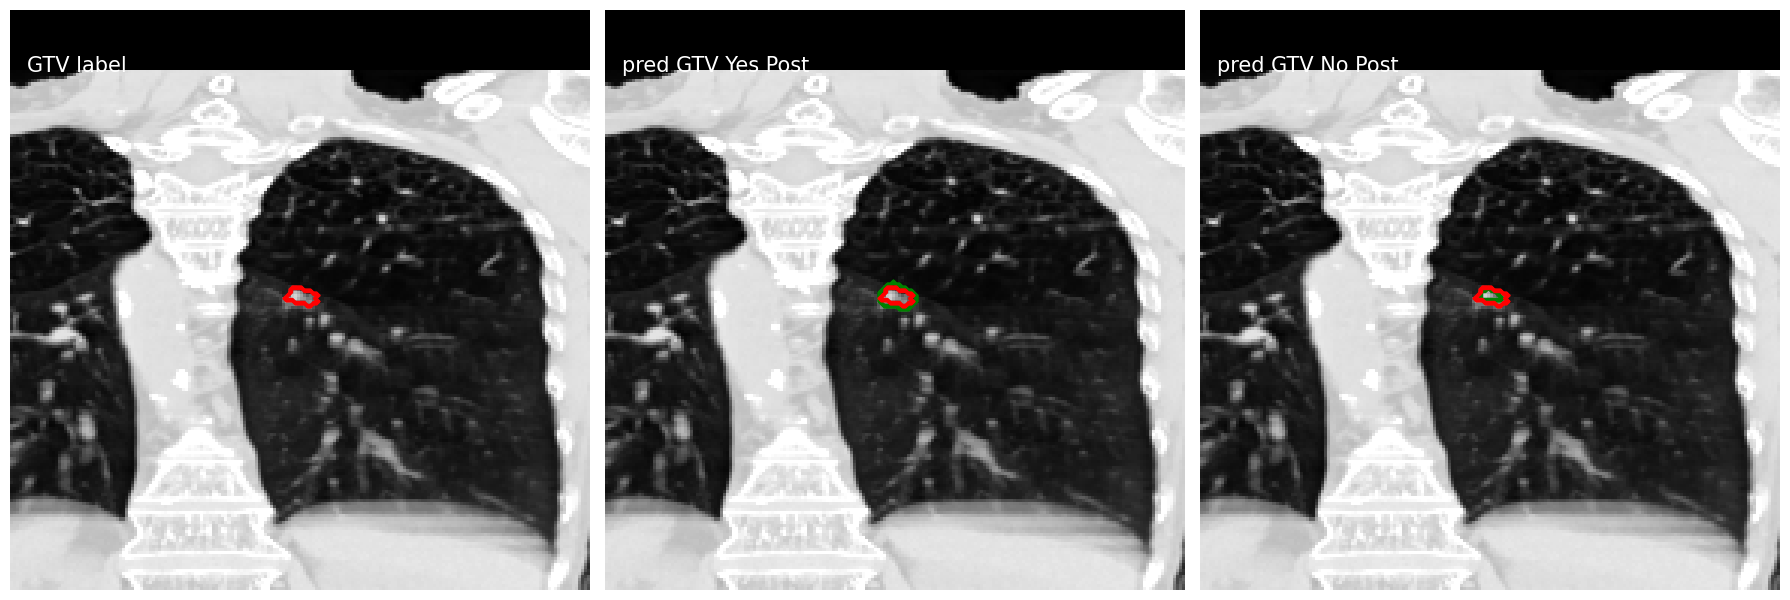

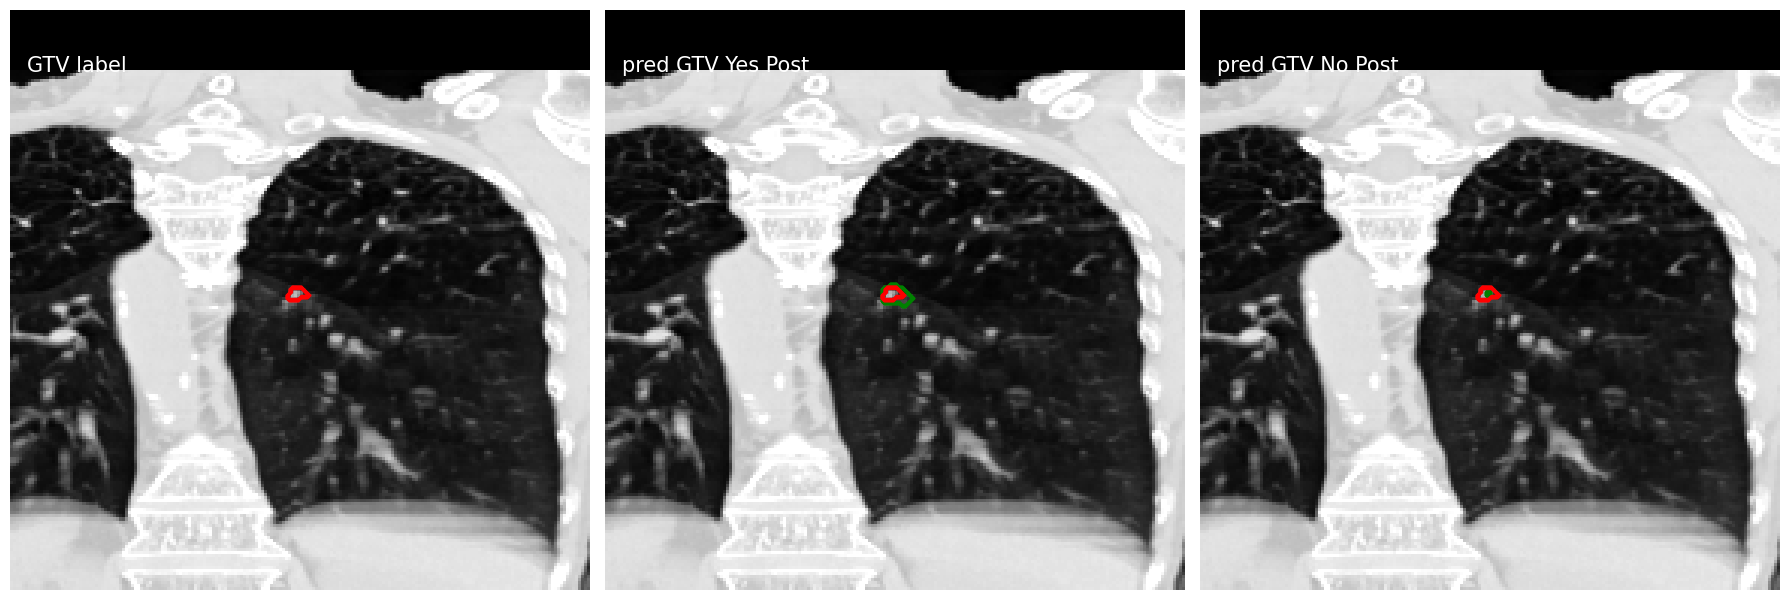

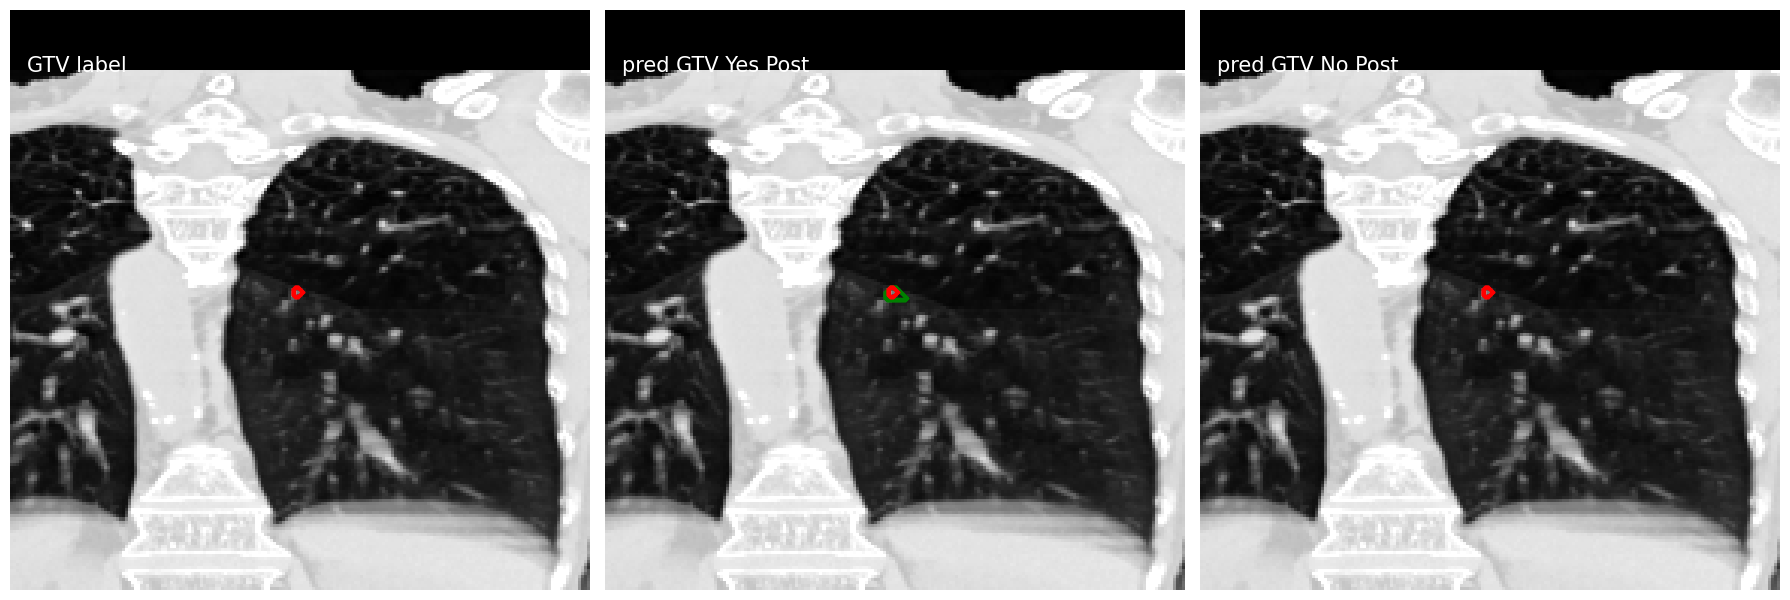

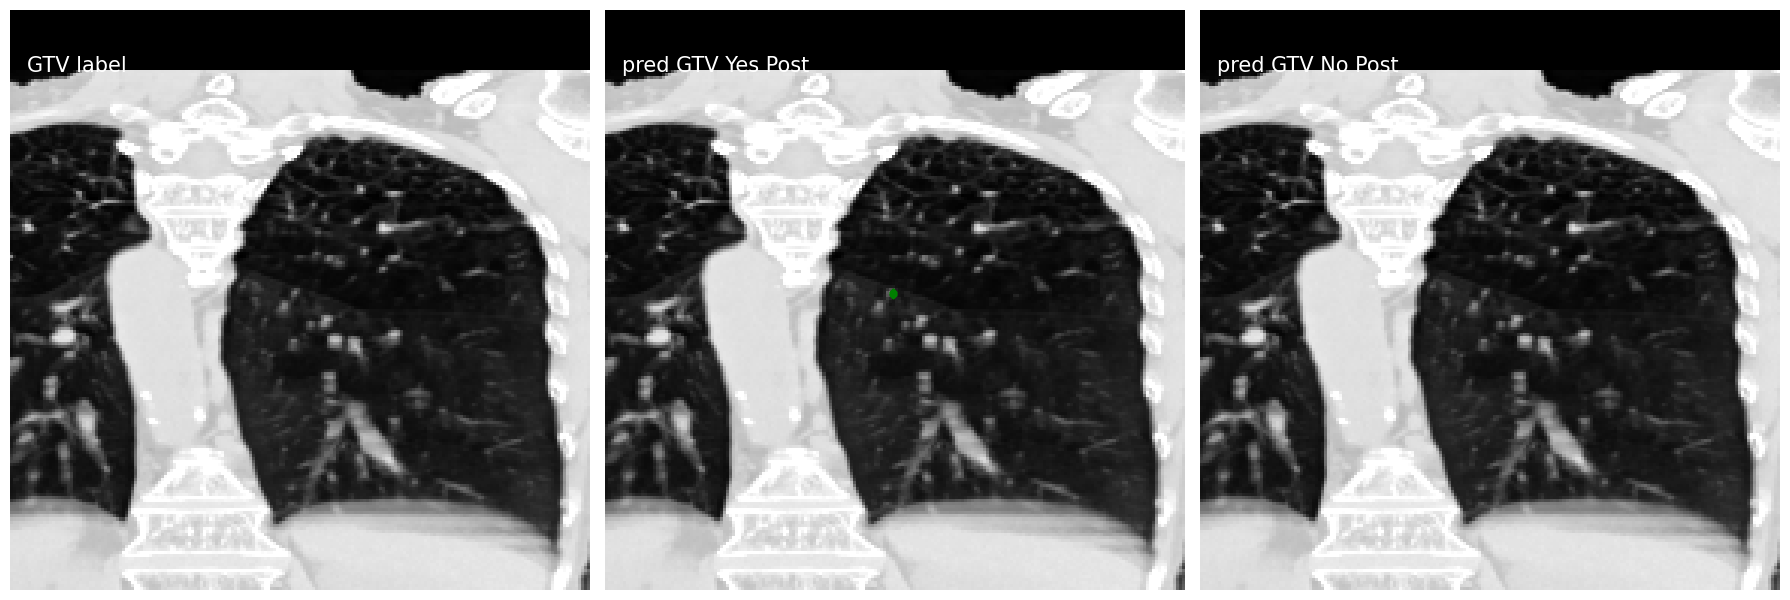

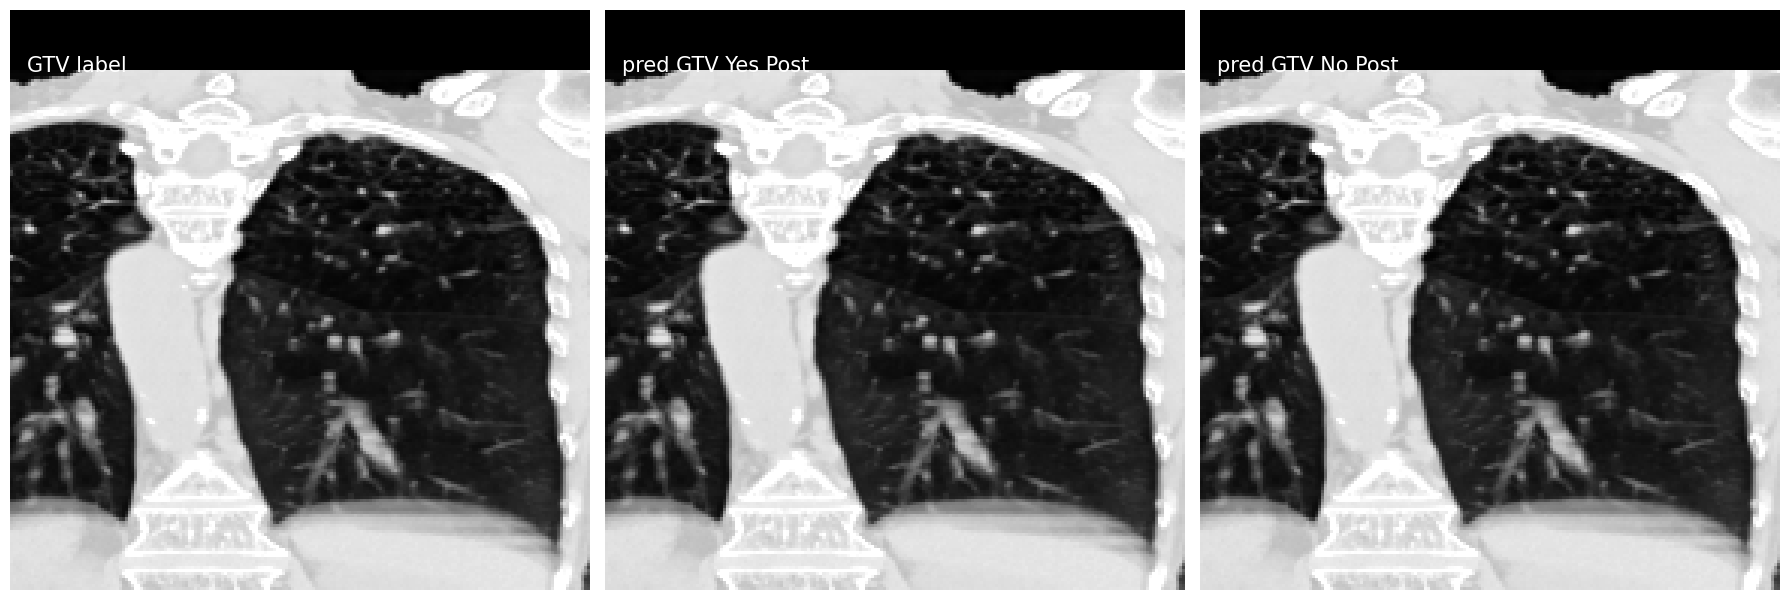

0

In [23]:
cmap = 'gray'
axial = True
sagital = False
coronal = True

itv_bool = False
gtv_bool = True
Withlabel = True
Overlap = True

custom_plot(px,cmap,axial,sagital,coronal,itv_bool,gtv_bool,Withlabel,Overlap)

In [18]:
def custom_plot(px,cmap,axial,sagital,coronal,itvbool,gtvbool,Withlabel,Overlap):
    print("Px:", px)
    #print(f"image shape: {image.shape},lung shape: {lung.shape}, label shape: {label_ITV.shape}, pITV_yes: {pITV_yes.shape},pITV_no: {pITV_no.shape},gtvyes:{gtv_yes.shape},gtvno:{gtv_no.shape}")
    count = 0
    if axial:
        for i in range(label_ITV.shape[-1]):
            if torch.sum(label_ITV[:,:,i])>0 or torch.sum(pITV_yes[:,:,i])>0 or torch.sum(pITV_no[:,:,i])>0:
                count+=1
                fig = plt.figure('Instance = {}'.format(0), figsize=figsize)
                warnings.filterwarnings("ignore")
                ax = fig.add_subplot(131)
                ax.imshow(np.rot90(image[:,:, i]),cmap='gray'),plt.axis('off')
                if Withlabel:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[:,:,i]),colors='yellow')
                        ax.text(5, 10, ['ITV Label',i], style='normal',color='white',fontsize=15)
                    if gtvbool:
                        ax.contour(np.rot90(gtv_label[:,:,i]),colors='red')
                        ax.text(5, 20, 'GTV label', style='normal',color='white',fontsize=15)
                
                ax = fig.add_subplot(132)
                ax.imshow(np.rot90(image[:,:, i]),cmap=cmap),plt.axis('off')
                if itvbool:
                    ax.contour(np.rot90(pITV_yes[:,:,i]),colors='cyan')
                    ax.text(5, 10, 'pred ITV Yes Post', style='normal',color='white',fontsize=15)
                if gtvbool:
                    ax.contour(np.rot90(gtv_yes[:,:,i]),colors='green')
                    ax.text(5, 20, 'pred GTV Yes Post', style='normal',color='white',fontsize=15)
                if Overlap:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[:,:,i]),colors='yellow')
                    if gtvbool:
                        ax.contour(np.rot90(gtv_label[:,:,i]),colors='red')
                
                ax = fig.add_subplot(133)
                ax.imshow(np.rot90(image[:,:,i]),cmap=cmap),plt.axis('off')
                if itvbool:
                    ax.contour(np.rot90(pITV_no[:,:,i]),colors='cyan')
                    ax.text(5, 10, 'pred ITV No Post', style='normal',color='white',fontsize=15)
                if gtvbool:
                    ax.contour(np.rot90(gtv_no[:,:,i]),colors='green')
                    ax.text(5, 20, 'pred GTV No Post', style='normal',color='white',fontsize=15)
                if Overlap:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[:,:,i]),colors='yellow')
                    if gtvbool:
                        ax.contour(np.rot90(gtv_label[:,:,i]),colors='red')
                plt.tight_layout(),plt.show()
                
    if sagital:
        print("SAGITAL")
        for i in range(label_ITV.shape[0]):
            if torch.sum(label_ITV[i,:,:])>0 or torch.sum(pITV_yes[i,:,:])>0 or torch.sum(pITV_no[i,:,:])>0:
                count+=1
                fig = plt.figure('Instance = {}'.format(0), figsize=figsize)
                ax = fig.add_subplot(131)
                ax.imshow(np.rot90(image[i,:,:]),cmap='gray'),plt.axis('off')
                if Withlabel:
                    if itv_bool:
                        ax.contour(np.rot90(label_ITV[i,:,:]),colors='yellow')
                        ax.text(5, 10, ['ITV Label',i], style='normal',color='white',fontsize=15)
                    if gtv_bool:
                        ax.contour(np.rot90(gtv_label[i,:,:]),colors='red')
                        ax.text(5, 20, 'GTV label', style='normal',color='white',fontsize=15)
                        
                
                ax = fig.add_subplot(132)
                ax.imshow(np.rot90(image[i,:,:]),cmap=cmap),plt.axis('off')
                if itvbool:
                    ax.contour(np.rot90(pITV_yes[i,:,:]),colors='cyan')
                    ax.text(5, 10, 'pred ITV Yes Post', style='normal',color='white',fontsize=15)
                if gtvbool:
                    ax.contour(np.rot90(gtv_yes[i,:,:]),colors='green')
                    ax.text(5, 20, 'pred GTV Yes Post', style='normal',color='white',fontsize=15)
                if Overlap:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[i,:,:]),colors='yellow')
                    if gtvbool:
                        ax.contour(np.rot90(gtv_label[i,:,:]),colors='red')
                
                ax = fig.add_subplot(133)
                ax.imshow(np.rot90(image[i,:,:]),cmap=cmap),plt.axis('off')
                if itvbool:
                    ax.contour(np.rot90(pITV_no[i,:,:]),colors='cyan')
                    ax.text(5, 10, 'pred ITV No Post', style='normal',color='white',fontsize=15)
                if gtvbool:
                    ax.contour(np.rot90(gtv_no[i,:,:]),colors='green')
                    ax.text(5, 20, 'pred GTV No Post', style='normal',color='white',fontsize=15)
                if Overlap:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[i,:,:]),colors='yellow')
                    if gtvbool:
                        ax.contour(np.rot90(gtv_label[i,:,:]),colors='red')
                plt.tight_layout(),plt.show()
    if coronal:
        print("Coronal")
        for i in range(label_ITV.shape[1]):
            if torch.sum(label_ITV[:,i,:])>0 or torch.sum(pITV_yes[:,i,:])>0 or torch.sum(pITV_no[:,i,:])>0:
                count+=1
                fig = plt.figure('Instance = {}'.format(0), figsize=figsize)
                ax = fig.add_subplot(131)
                ax.imshow(np.rot90(image[:,i,:]),cmap='gray'),plt.axis('off')
                if Withlabel:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[:,i,:]),colors='yellow')
                        ax.text(5, 10, ['ITV Label',i], style='normal',color='white',fontsize=15)
                    if gtvbool:
                            ax.contour(np.rot90(gtv_label[:,i,:]),colors='red')
                            ax.text(5, 20, 'GTV label', style='normal',color='white',fontsize=15)
                
                
                ax = fig.add_subplot(132)
                ax.imshow(np.rot90(image[:,i,:]),cmap=cmap),plt.axis('off')
                if itvbool:
                    ax.contour(np.rot90(pITV_yes[:,i,:]),colors='cyan')
                    ax.text(5, 10, 'pred ITV Yes Post', style='normal',color='white',fontsize=15)
                if gtvbool:
                    ax.contour(np.rot90(gtv_yes[:,i,:]),colors='green')
                    ax.text(5, 20, 'pred GTV Yes Post', style='normal',color='white',fontsize=15)
                if Overlap:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[:,i,:]),colors='yellow')
                    if gtvbool:
                        ax.contour(np.rot90(gtv_label[:,i,:]),colors='red')
               
                ax = fig.add_subplot(133)
                ax.imshow(np.rot90(image[:,i,:]),cmap=cmap),plt.axis('off')
                if itvbool:
                    ax.contour(np.rot90(pITV_no[:,i,:]),colors='cyan')
                    ax.text(5, 10, 'pred ITV No Post', style='normal',color='white',fontsize=15)
                if gtvbool:
                    ax.contour(np.rot90(gtv_no[:,i,:]),colors='green')                
                    ax.text(5, 20, 'pred GTV No Post', style='normal',color='white',fontsize=15)
                if Overlap:
                    if itvbool:
                        ax.contour(np.rot90(label_ITV[:,i,:]),colors='yellow')
                    if gtvbool:
                        ax.contour(np.rot90(gtv_label[:,i,:]),colors='red')
                plt.tight_layout(),plt.show()
    return 0